#  Task B

Fourier series are not only useful for 1D signals, they can also approximate complex 2D shapes and contours. In this exercise, you will explore how a 2D drawing can be represented through Fourier series.

In [1]:
!pip install svgpathtools lxml pandas --quiet
!pip install cairosvg --quiet

In [2]:
import math, csv, pathlib, os
import numpy as np
import xml.etree.ElementTree as ET
from svgpathtools import parse_path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
from IPython.display import SVG, display
import cairosvg
import pathlib

**(a) Data Preparation: Choose or create an SVG image that approximates the IIT Guwahati logo.**

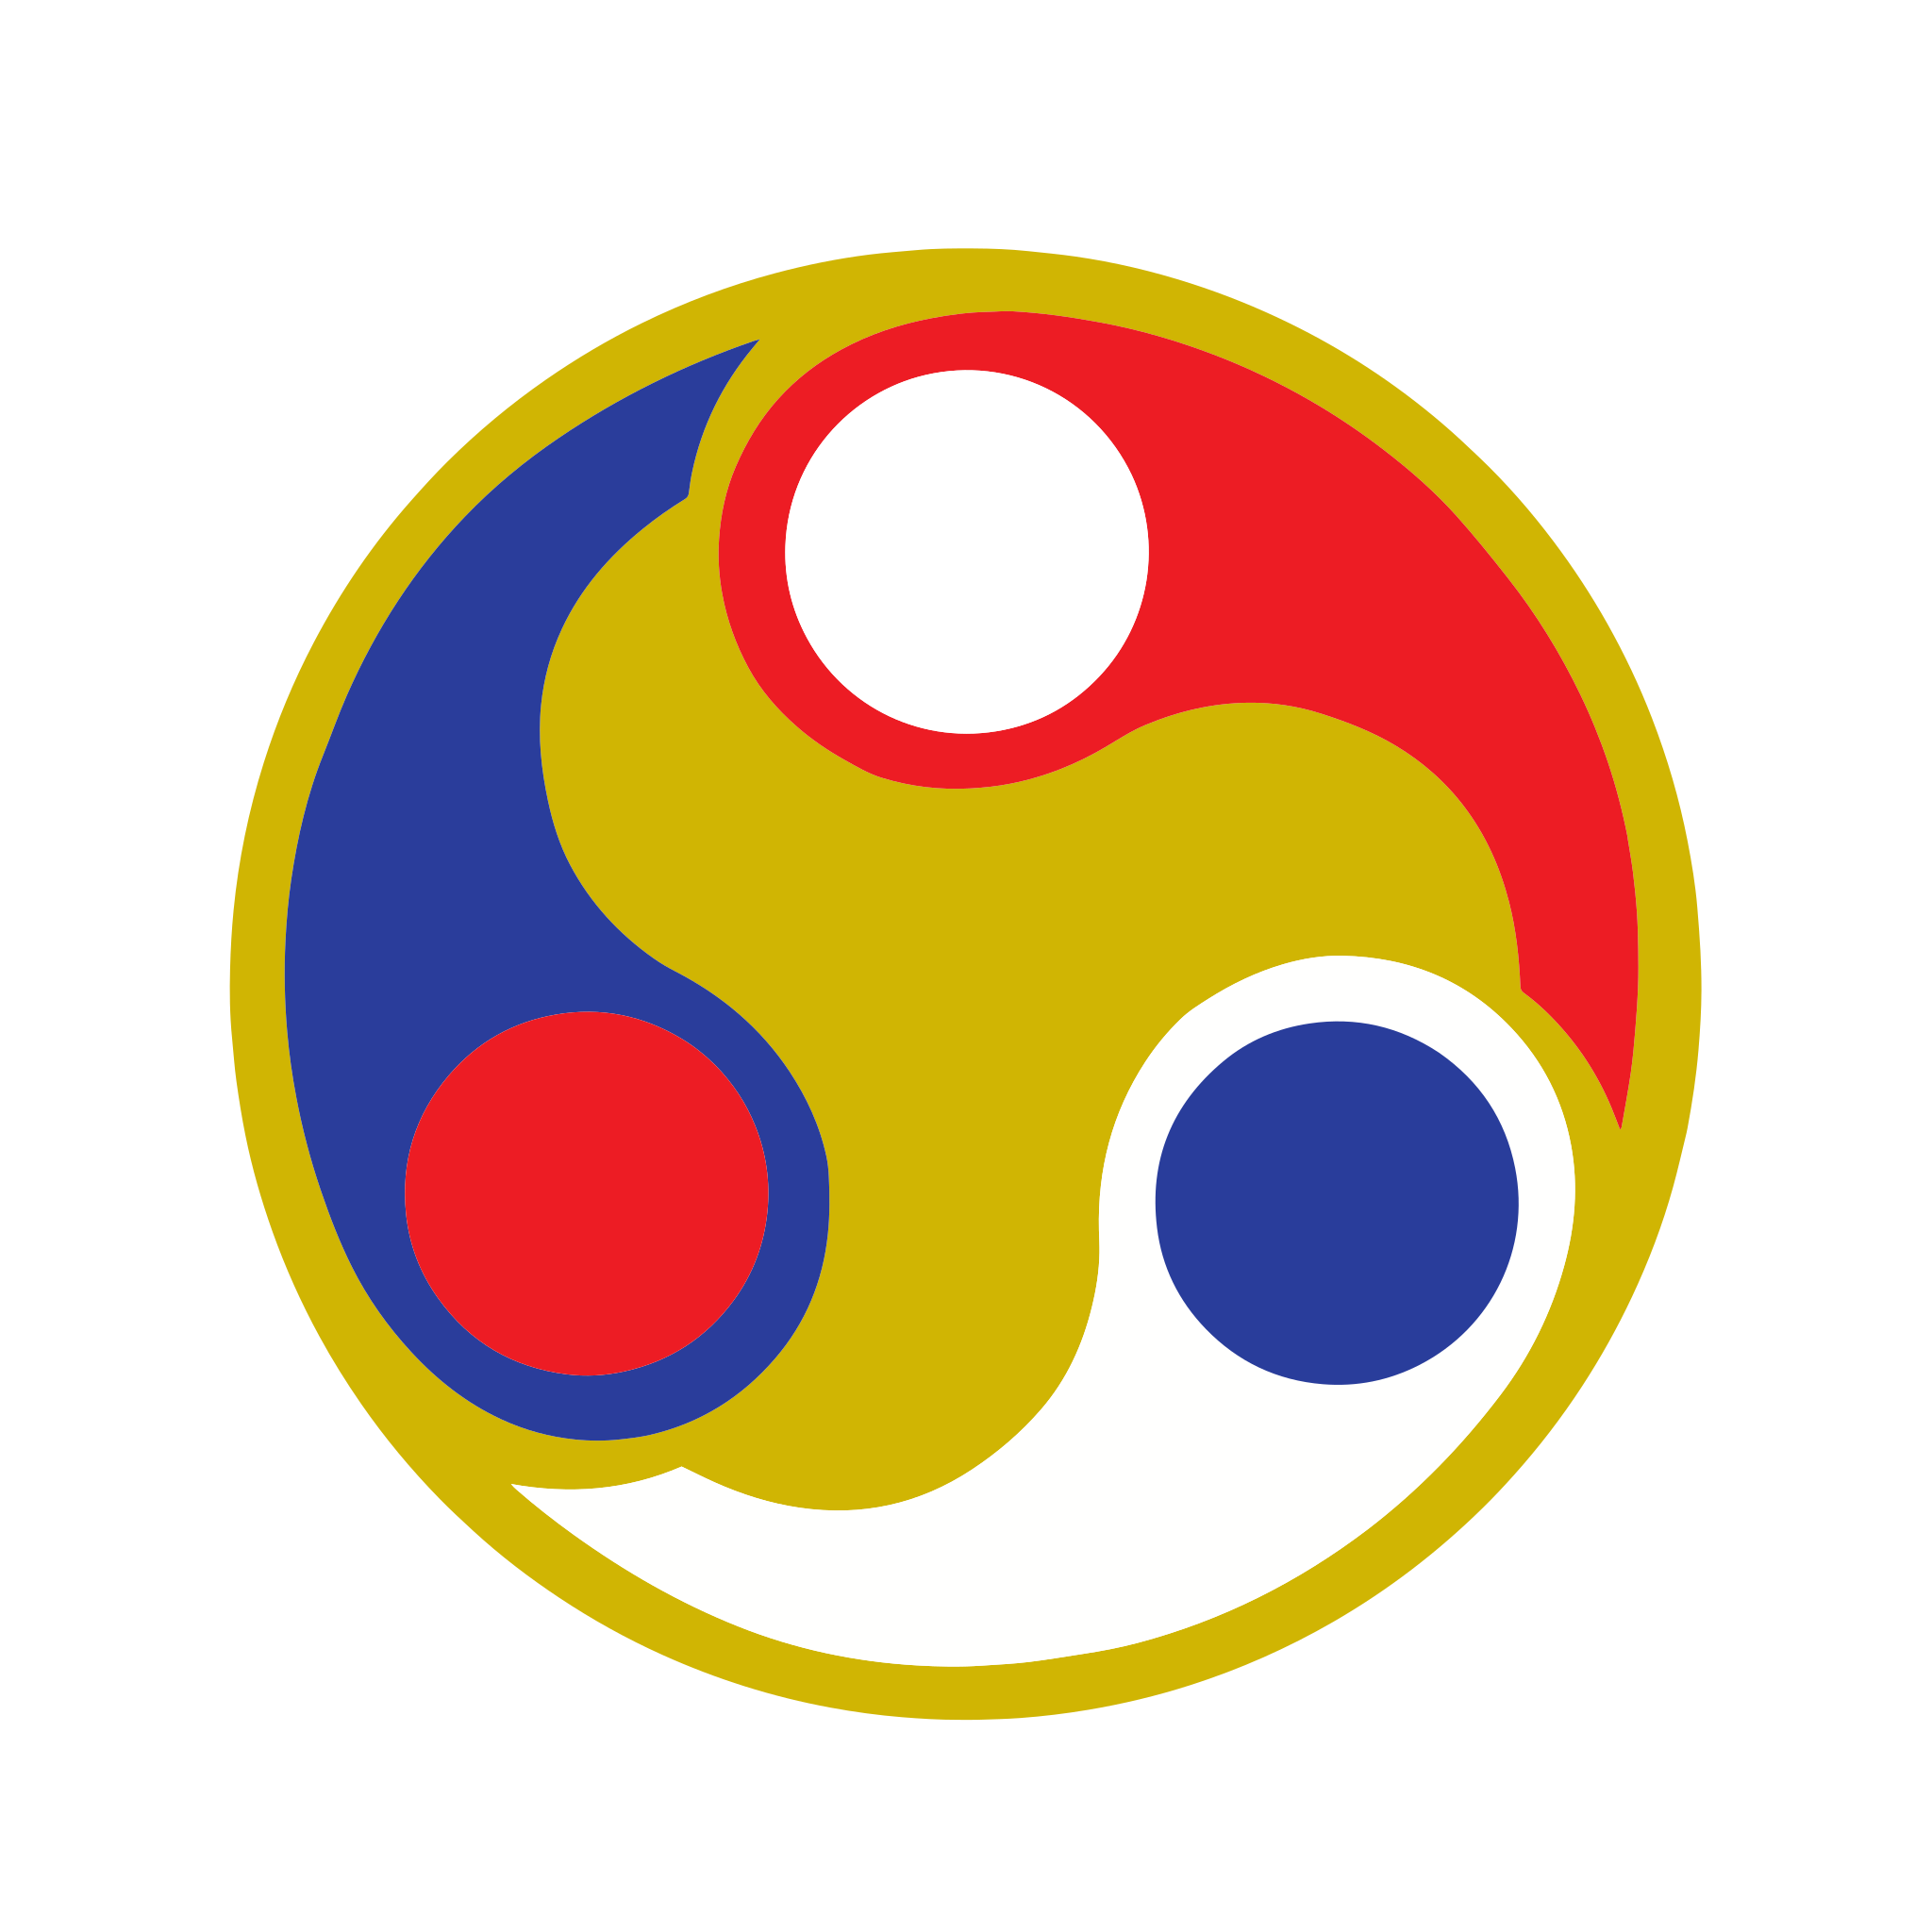

Displayed SVG file preview: IITG_LOGO.svg


In [3]:
svg_file_path = "IITG_LOGO.svg"

display(SVG(svg_file_path))
print("Displayed SVG file preview:", svg_file_path)

Data Preparation: Extract the ordered coordinates (x, y) of the points along the contour.


Extract the ordered coordinates (x, y) and a time index for points along the contours of each subfigure within the "iitg logo svg" file. Store the location of each subfigure for later reconstruction. Use multiple cells to perform the extraction and sampling process, treating the x and y axis projections as the sampled points and the time taken to trace the boundary as the time index. The output should include the modified cell id(s).

In [4]:
tree = ET.parse(svg_file_path)
root = tree.getroot()

ns = {'svg': 'http://www.w3.org/2000/svg'}

paths = []
for path_element in root.findall('.//svg:path', ns):
    path_data = path_element.get('d')
    if path_data:
        paths.append(path_data)

print(f"Found {len(paths)} path elements.")

Found 8 path elements.


Iterate through paths and sample points


In [5]:
sampled_points = []
num_points_per_path = 200

for path_data in paths:
    path_obj = parse_path(path_data)
    path_length = path_obj.length()
    t_values = np.linspace(0, 1, num_points_per_path)

    for t in t_values:
        point = path_obj.point(t)
        sampled_points.append((point.real, point.imag))

print(f"Sampled {len(sampled_points)} points from all paths.")

Sampled 1600 points from all paths.


In [6]:
points_list = []
path_points_count = num_points_per_path

for i, (x, y) in enumerate(sampled_points):
    path_id = i // path_points_count
    time_index = i % path_points_count
    points_list.append({'x': x, 'y': y, 'time_index': time_index, 'path_id': path_id})

df_points = pd.DataFrame(points_list)
display(df_points.head())

x       y  time_index  path_id
0  2138.000000  3680.0           0        0
1  2019.744502  3680.0           1        0
2  1901.506347  3680.0           2        0
3  1783.284518  3680.0           3        0
4  1665.078001  3680.0           4        0

In [7]:
display(df_points.head())
display(df_points.info())

x       y  time_index  path_id
0  2138.000000  3680.0           0        0
1  2019.744502  3680.0           1        0
2  1901.506347  3680.0           2        0
3  1783.284518  3680.0           3        0
4  1665.078001  3680.0           4        0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           1600 non-null   float64
 1   y           1600 non-null   float64
 2   time_index  1600 non-null   int64  
 3   path_id     1600 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 50.1 KB


None

Visualize extracted points



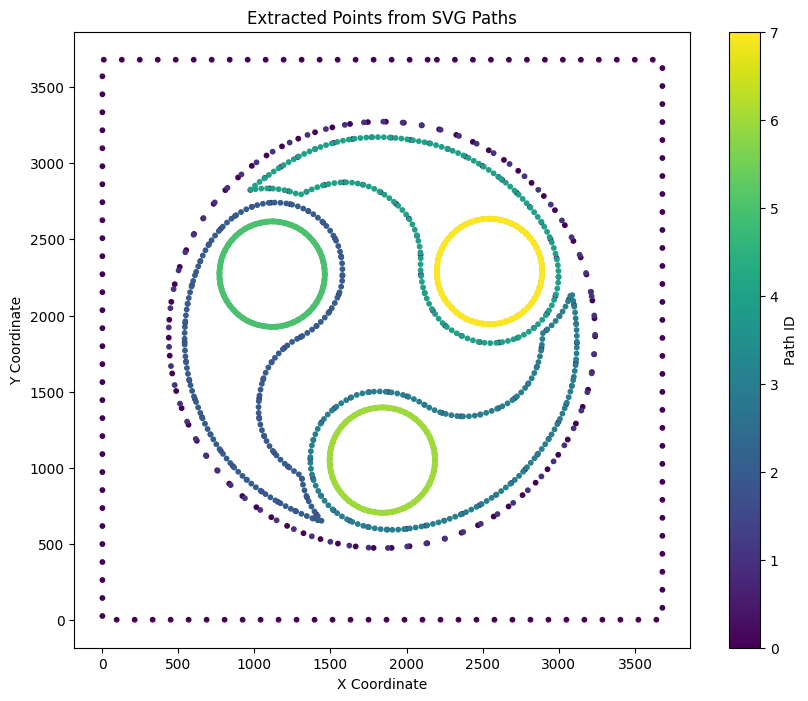

In [8]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_points['x'], df_points['y'], c=df_points['path_id'], cmap='viridis', s=10)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Extracted Points from SVG Paths")
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(scatter, label='Path ID')
plt.show()

**(b) Treat x(t) and y(t) (the coordinates as parametric functions of traversal along the curve) as two separate signals.**

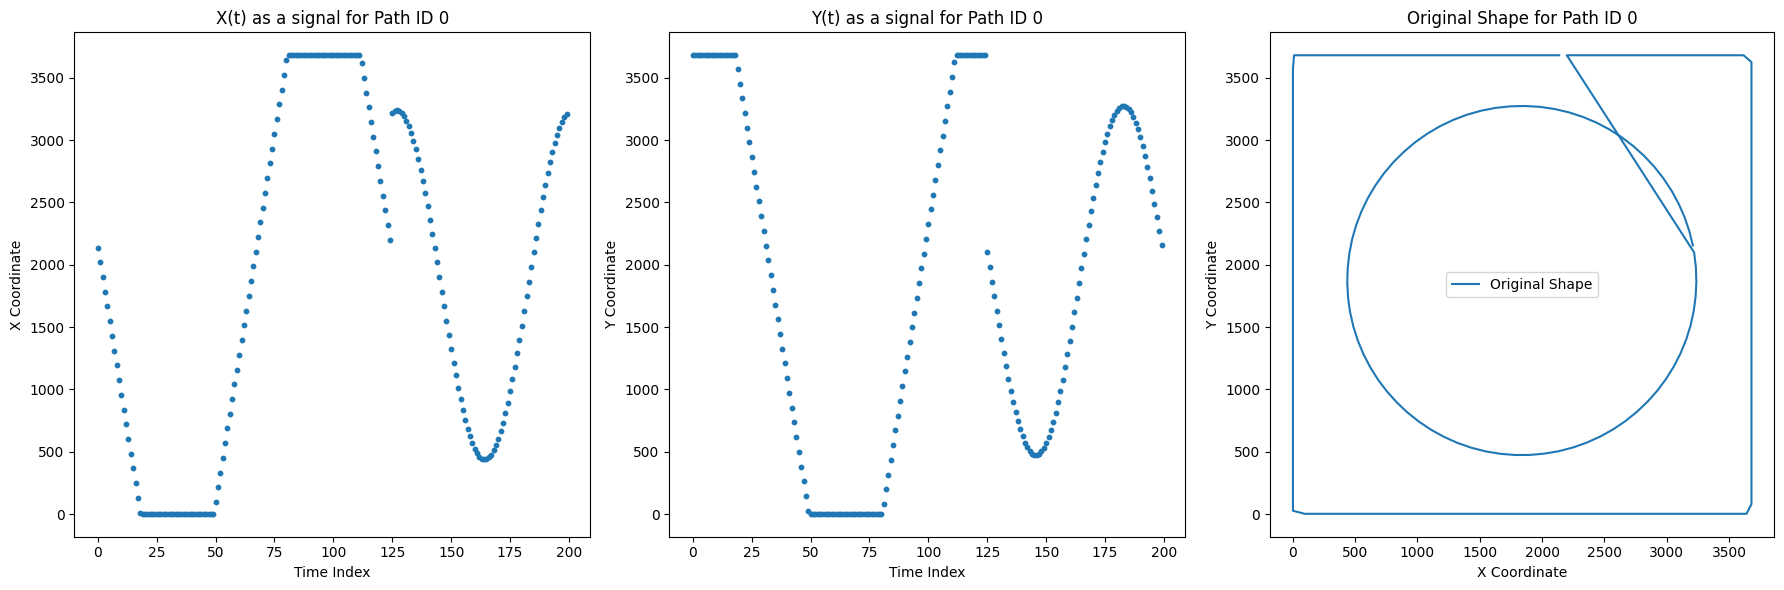

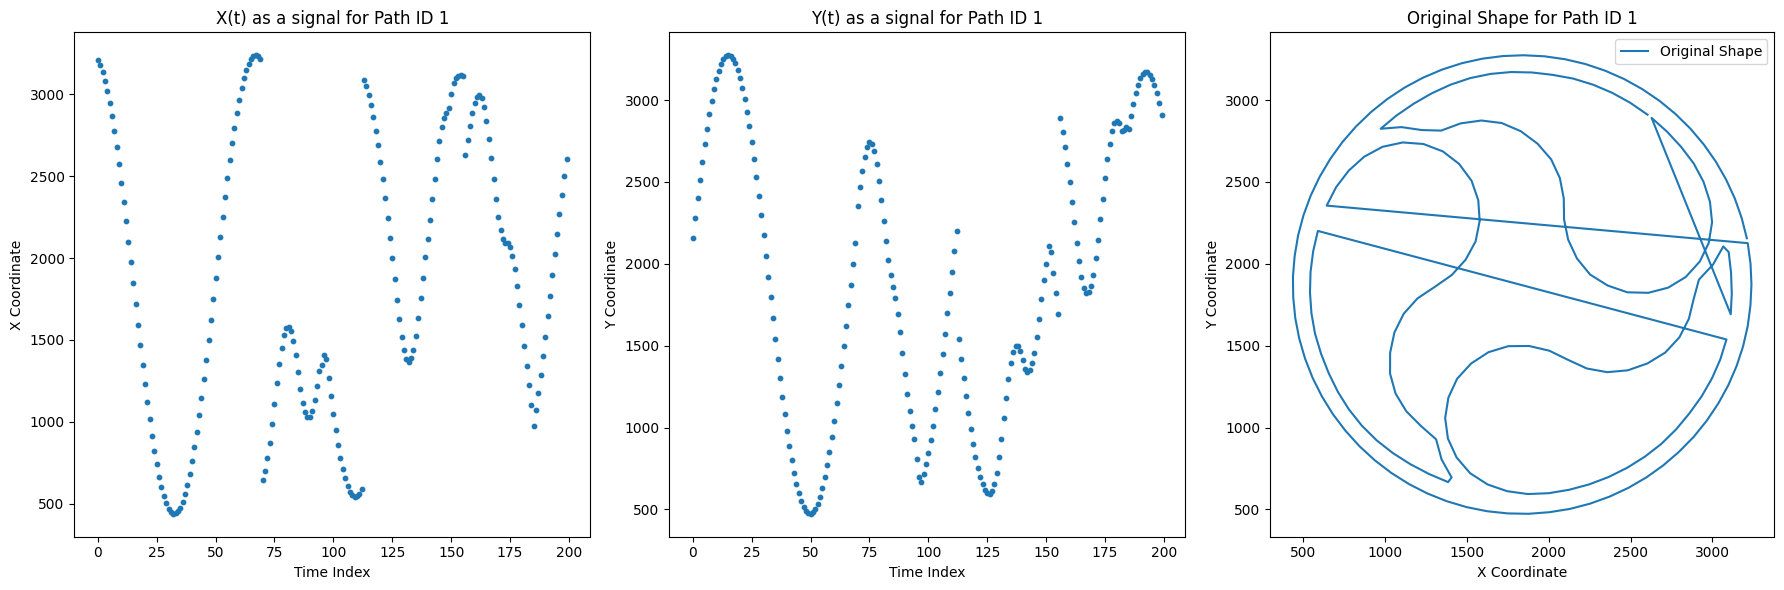

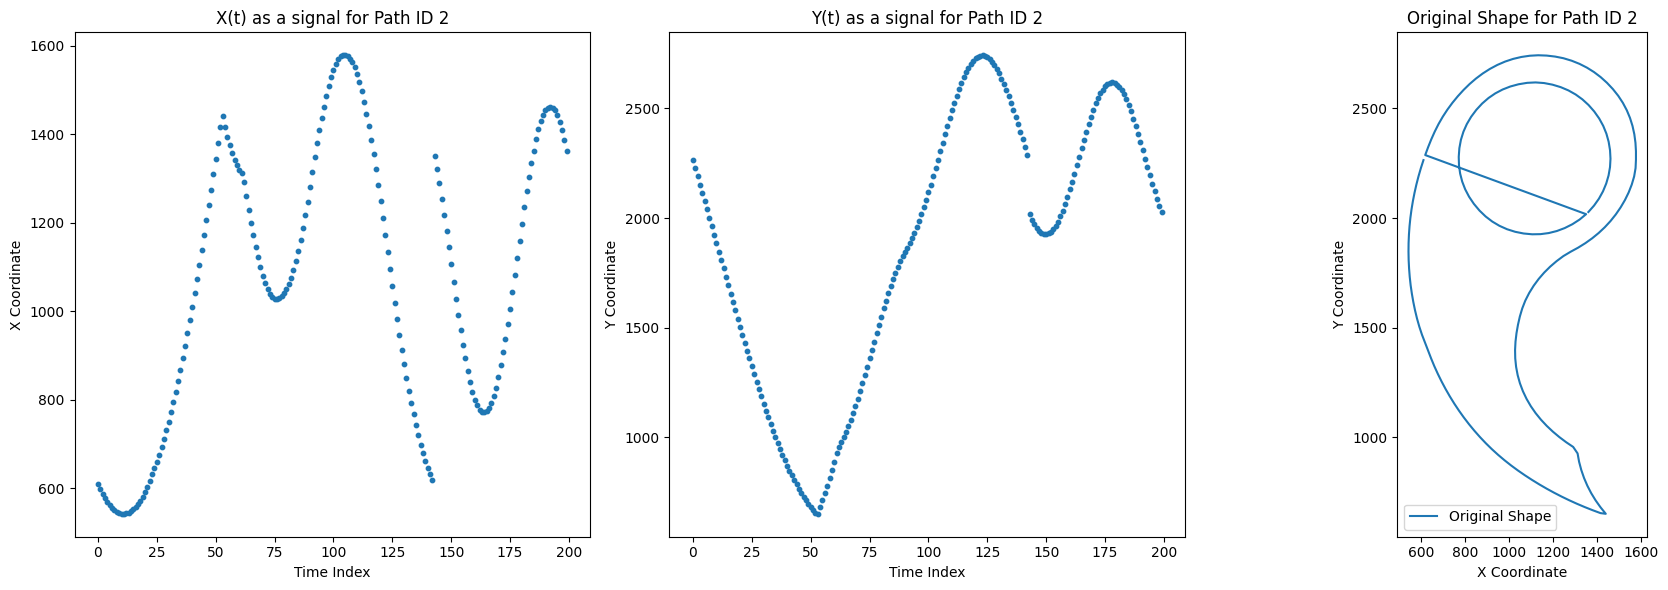

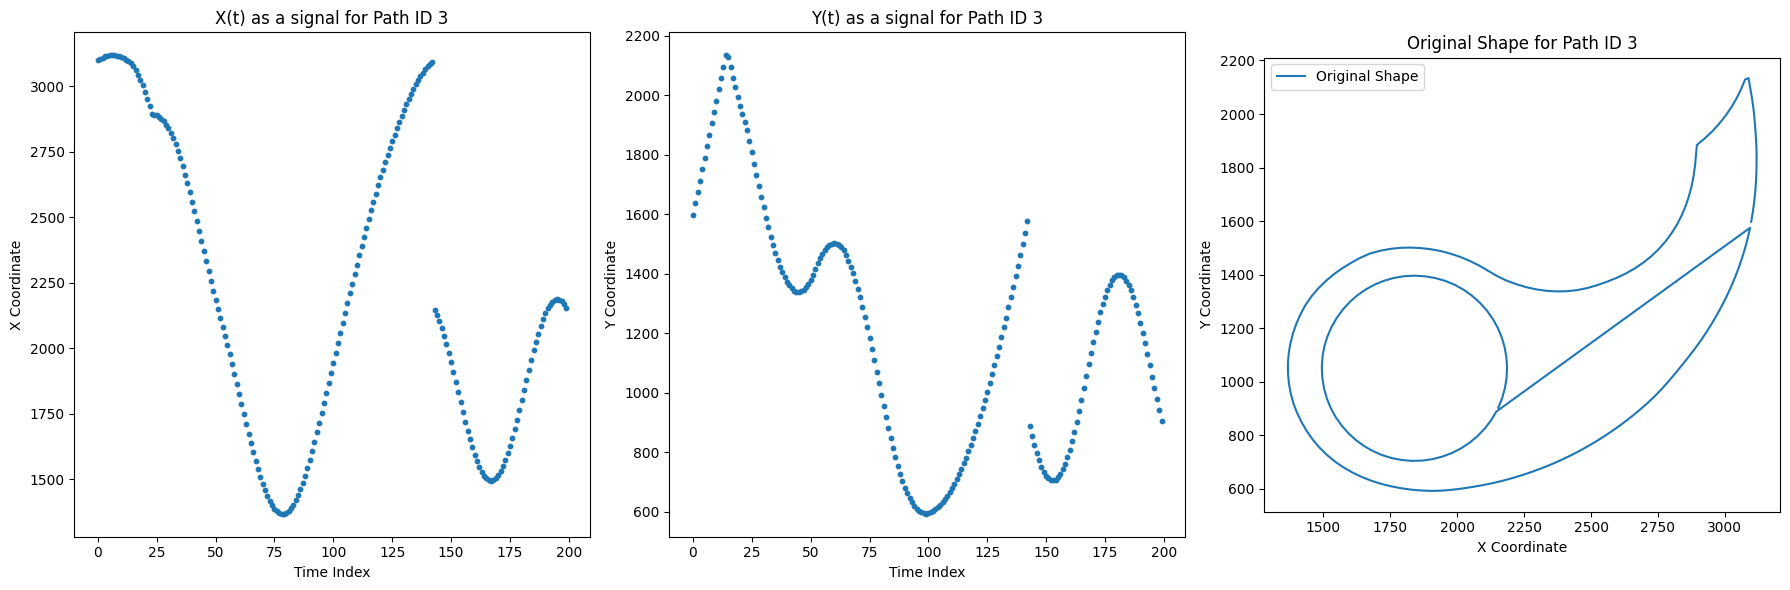

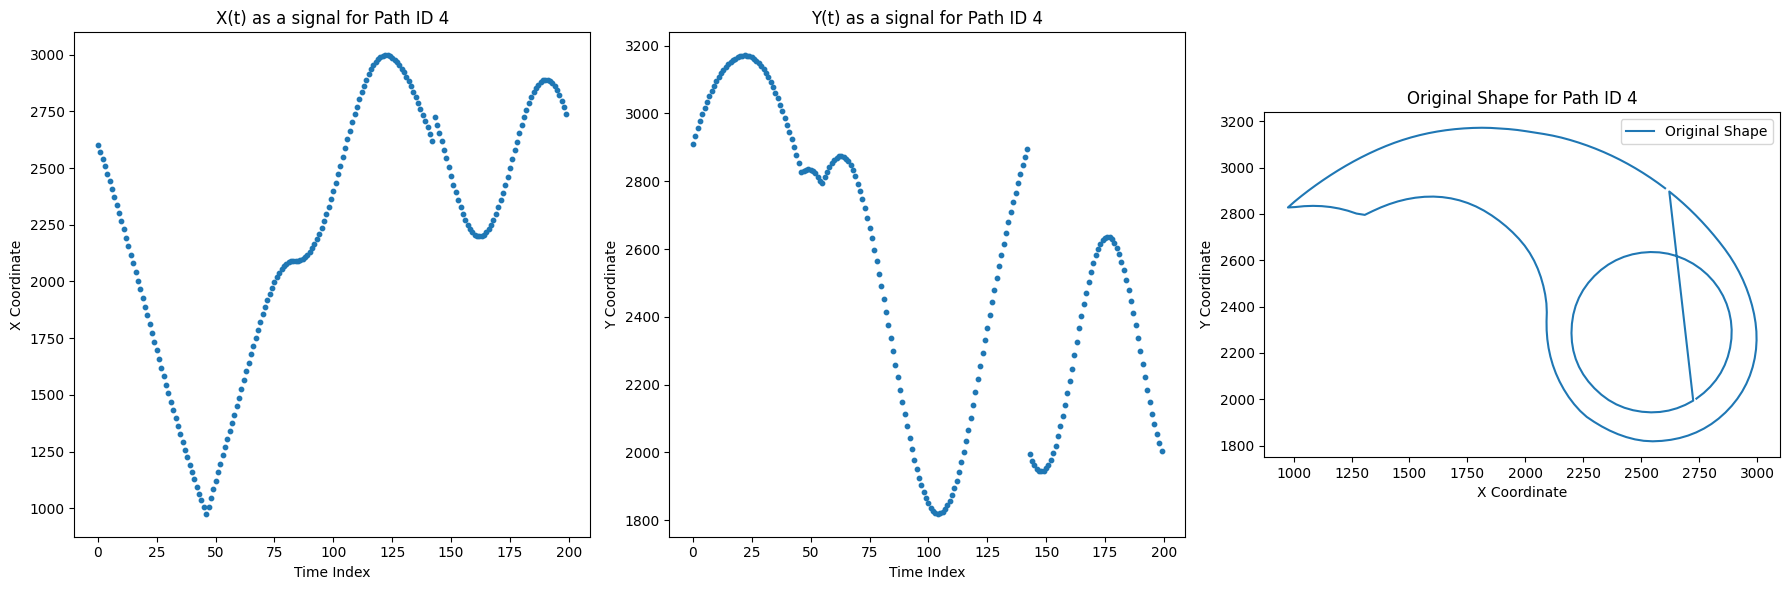

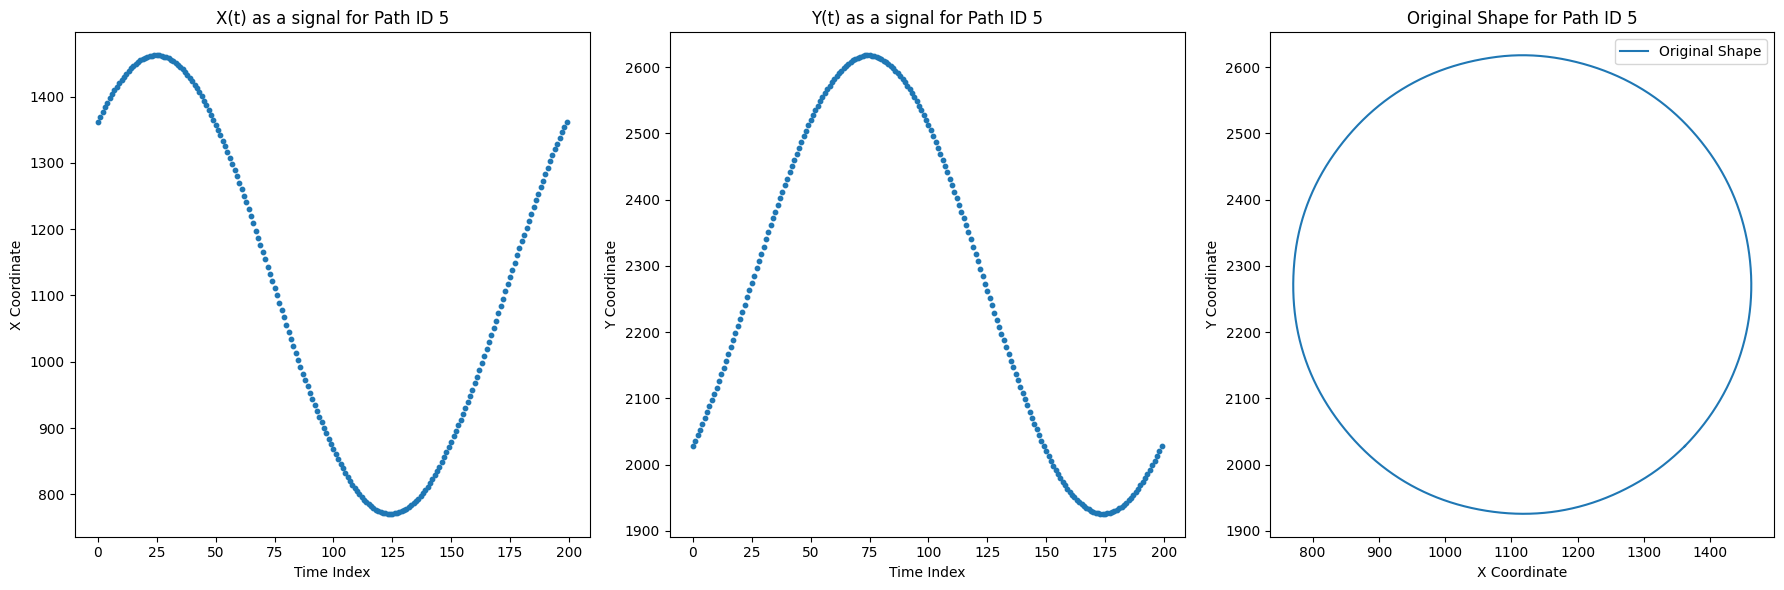

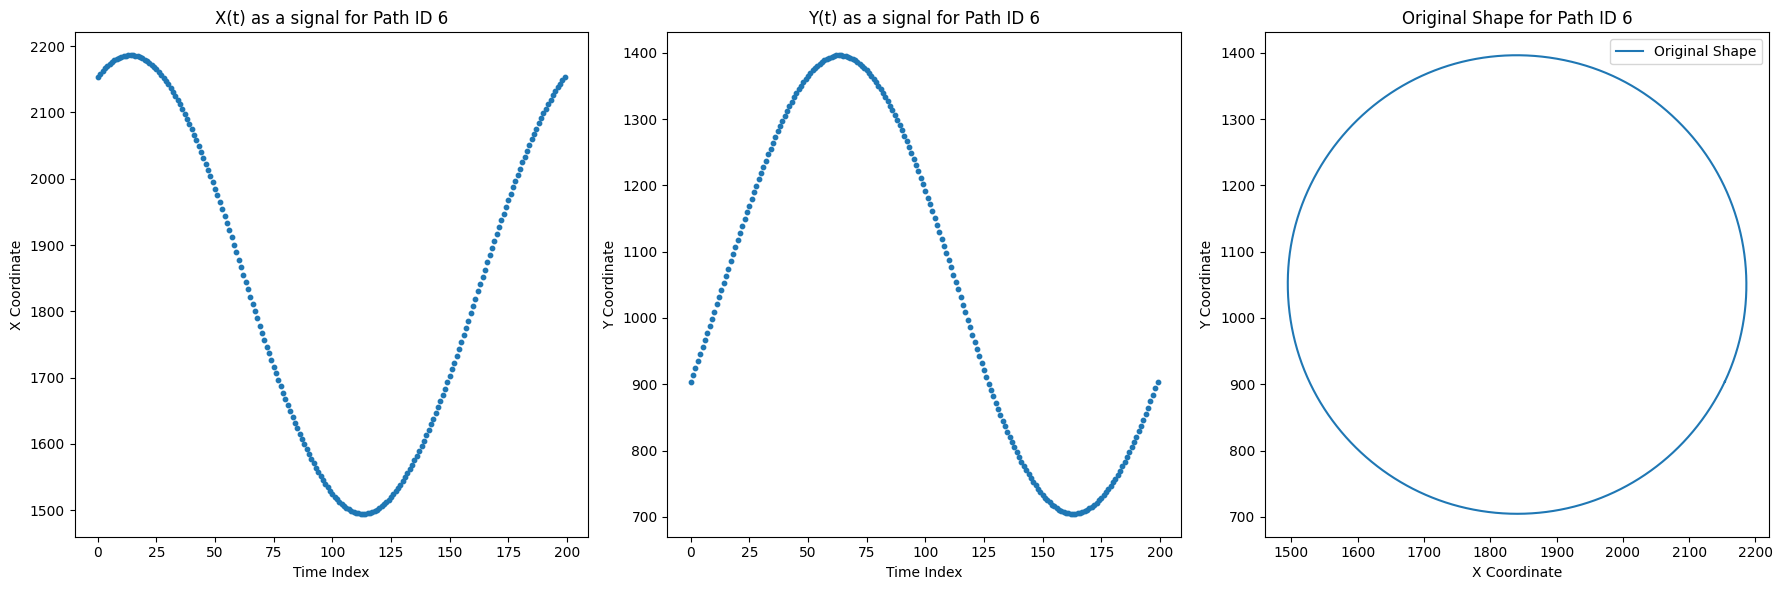

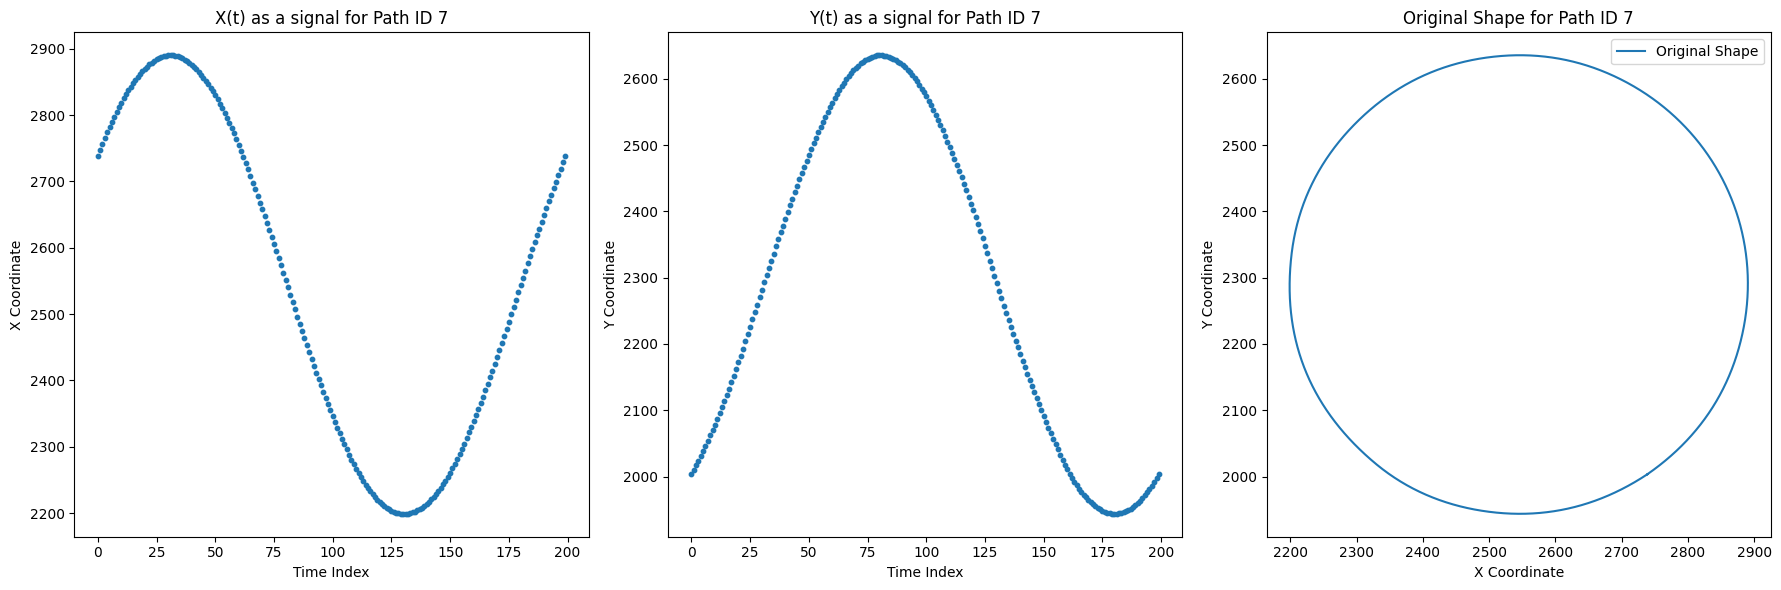

In [28]:
unique_path_ids = df_points['path_id'].unique()

for path_id in unique_path_ids:
    df_subset = df_points[df_points['path_id'] == path_id].sort_values(by='time_index') # Ensure points are in order for plotting the shape

    plt.figure(figsize=(18, 6))

    # Plot x(t) for the current path ID
    plt.subplot(1, 3, 1)
    plt.scatter(df_subset['time_index'], df_subset['x'], s=10)
    plt.xlabel("Time Index")
    plt.ylabel("X Coordinate")
    plt.title(f"X(t) as a signal for Path ID {path_id}")

    # Plot y(t) for the current path ID
    plt.subplot(1, 3, 2)
    plt.scatter(df_subset['time_index'], df_subset['y'], s=10)
    plt.xlabel("Time Index")
    plt.ylabel("Y Coordinate")
    plt.title(f"Y(t) as a signal for Path ID {path_id}")

    # Plot the original shape (x vs y) for the current path ID
    plt.subplot(1, 3, 3)
    plt.plot(df_subset['x'], df_subset['y'], label='Original Shape') # Use plot for connected points
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"Original Shape for Path ID {path_id}")
    plt.gca().set_aspect('equal', adjustable='box') # Maintain aspect ratio
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def compute_Fourier_Series(x, t, K):

    x = np.asarray(x)
    N = len(x)
    t = np.arange(N)

    if N == 0:
        return np.array([])

    k0 = - (K // 2)
    k = np.arange(k0, k0 + K)

    # DFT formula: c_k = (1/N) * sum_{n=0}^{N-1} x[n] * exp(-j * 2 * pi * k * n / N)
    c = np.zeros(K, dtype=complex)
    for i, freq in enumerate(k):
        c[i] = (1/N) * np.sum(x * np.exp(-1j * 2.0 * np.pi * freq * t / N))

    return c

Compute their Fourier coefficients using compute_Fourier_Series().

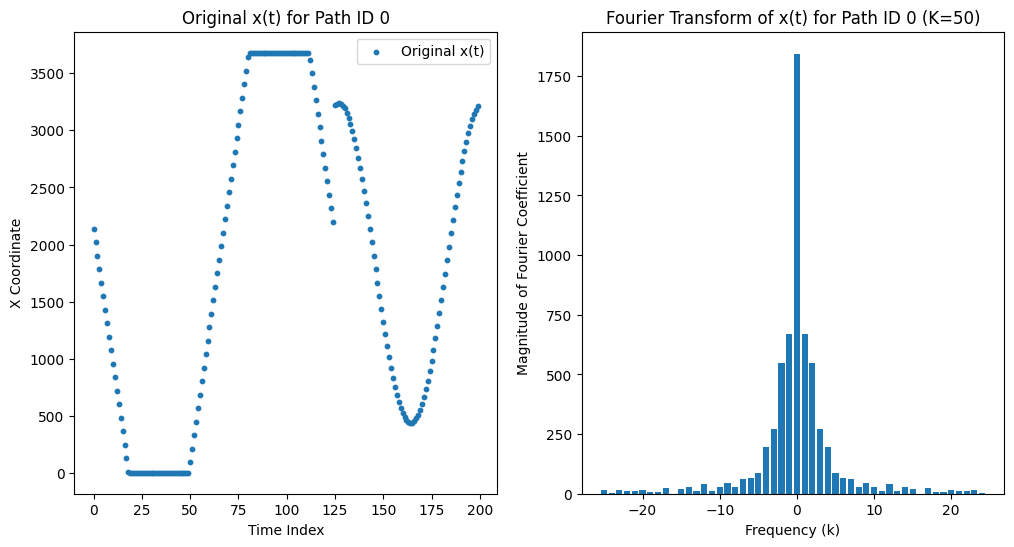

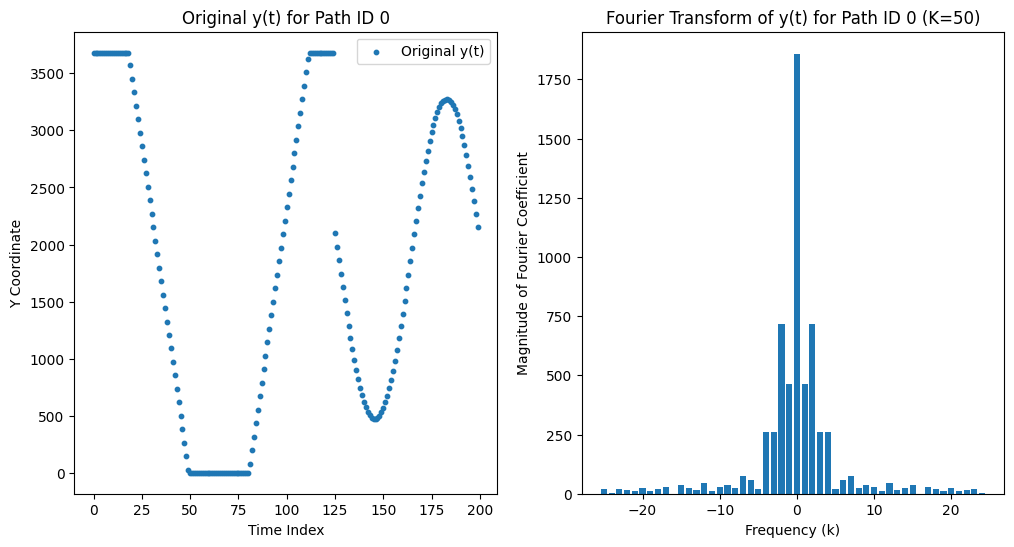

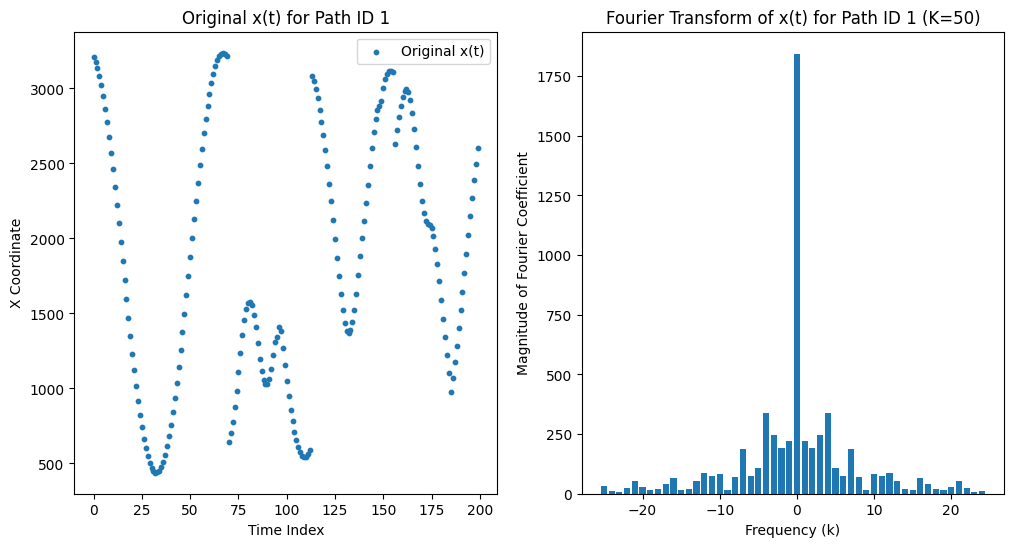

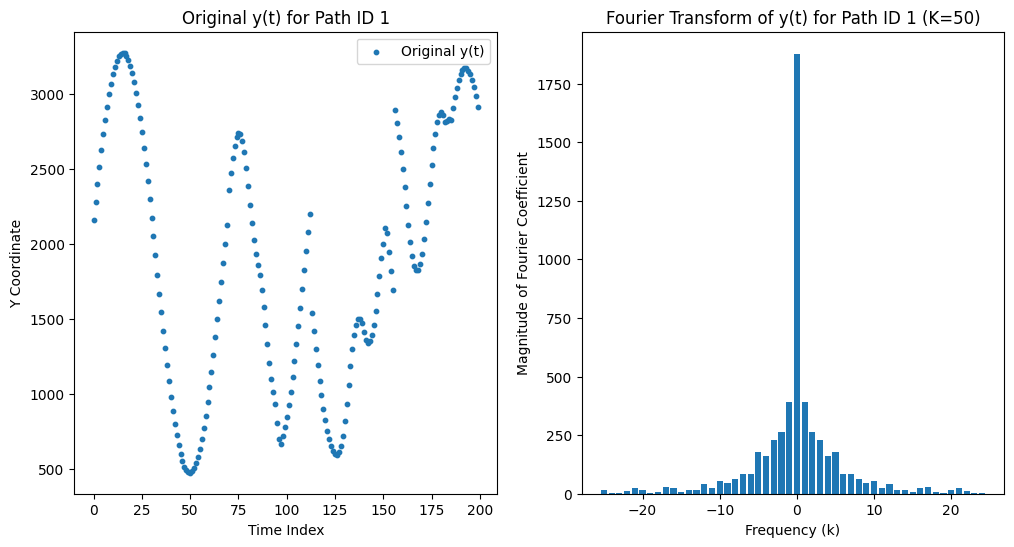

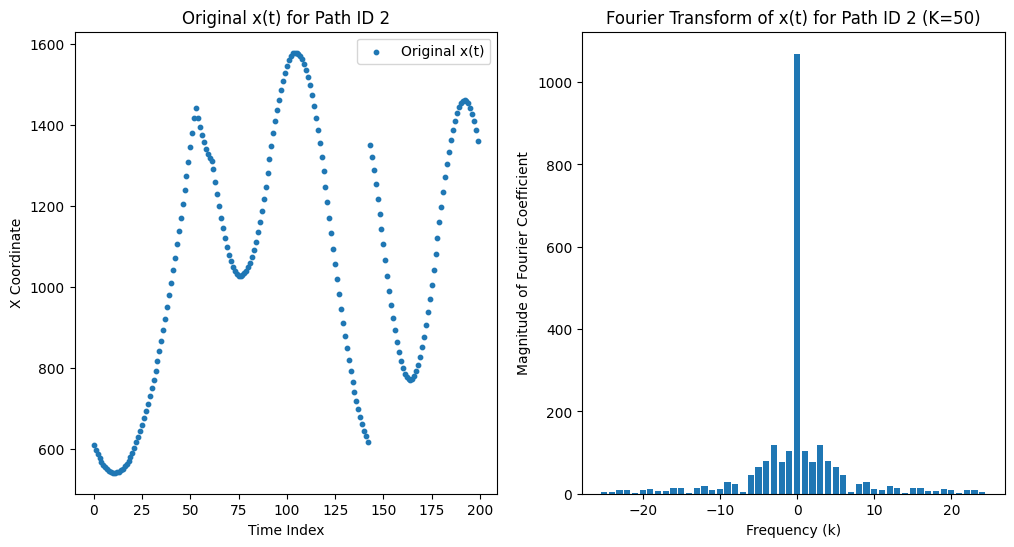

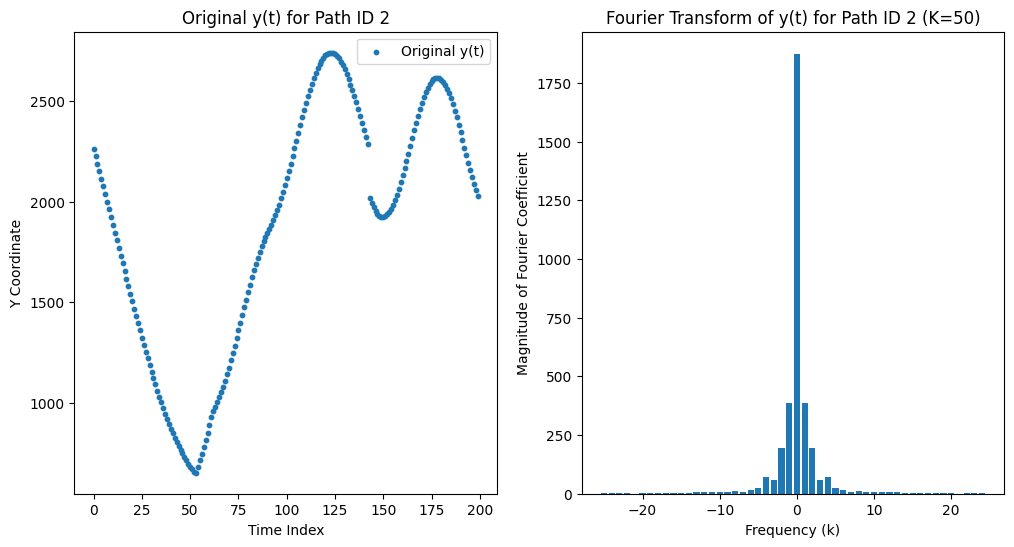

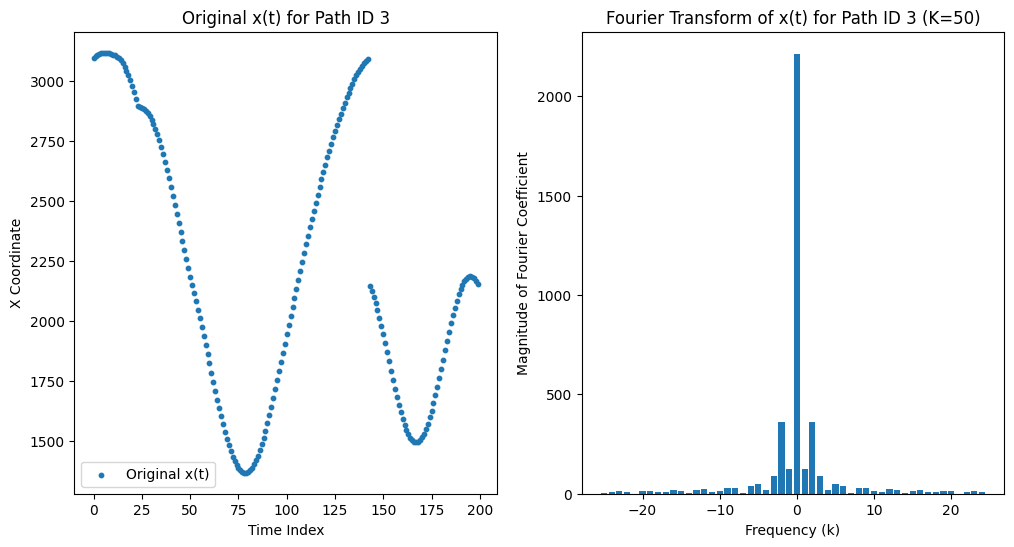

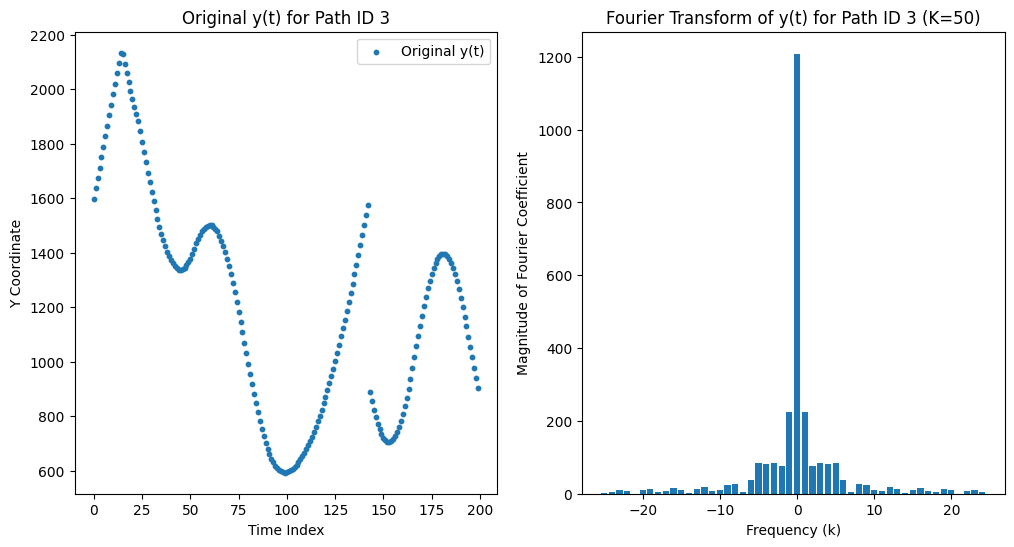

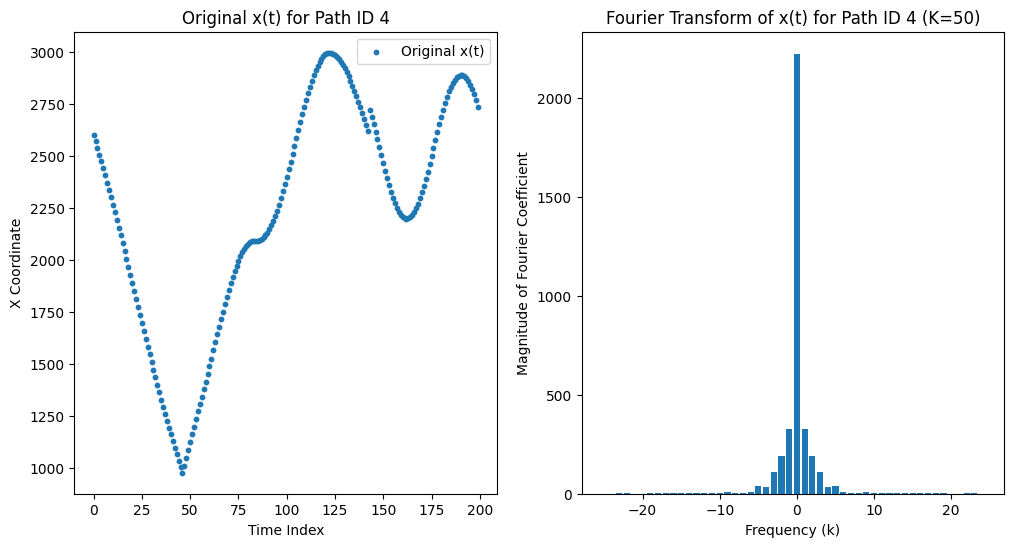

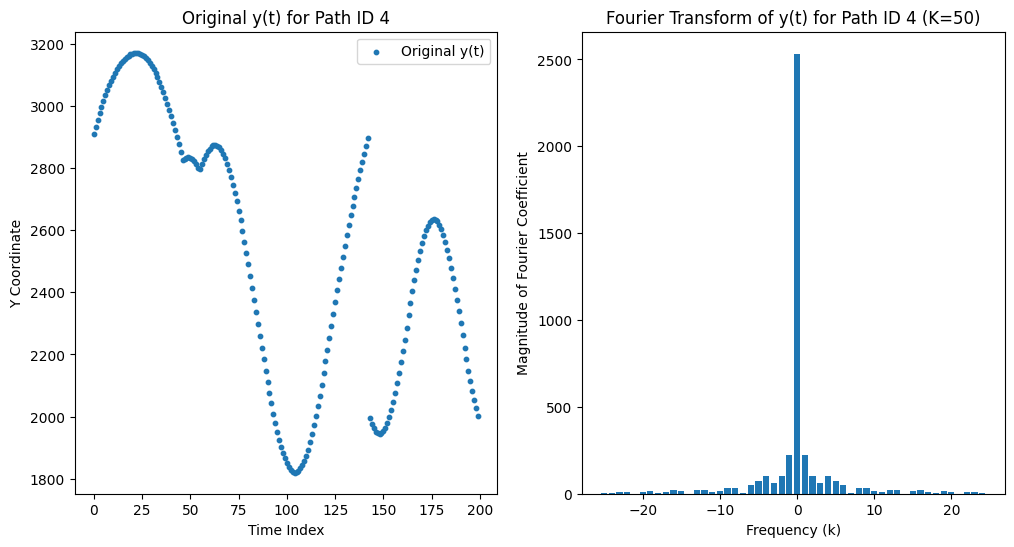

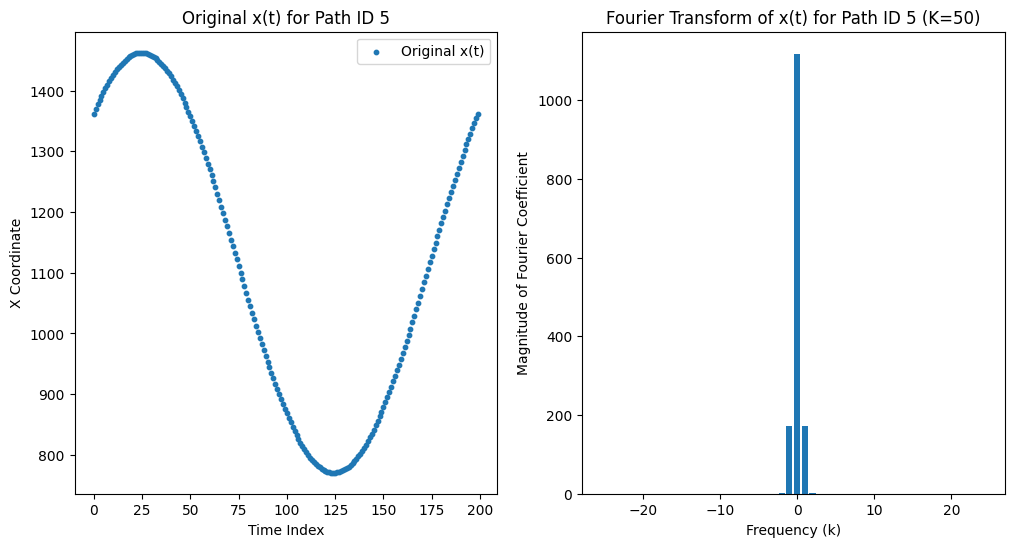

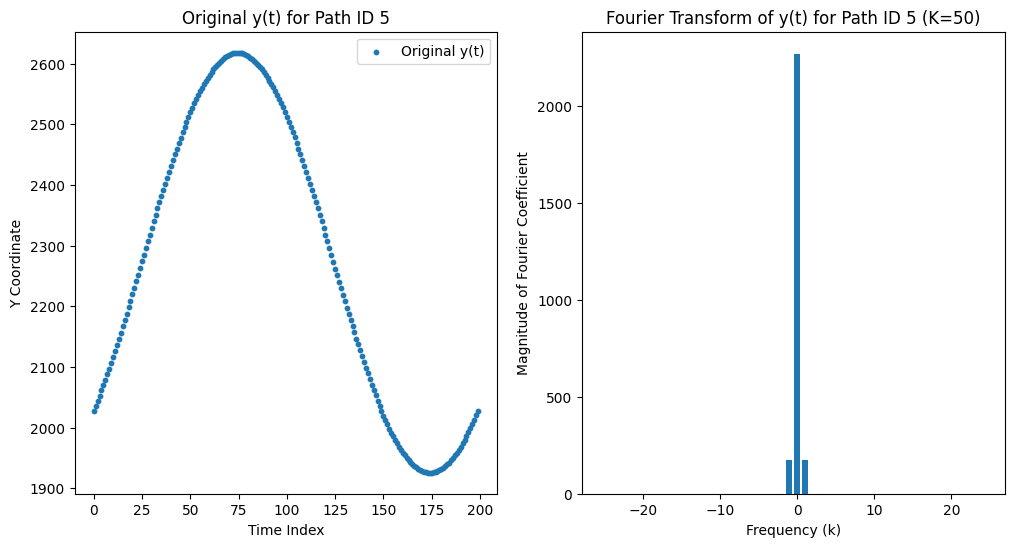

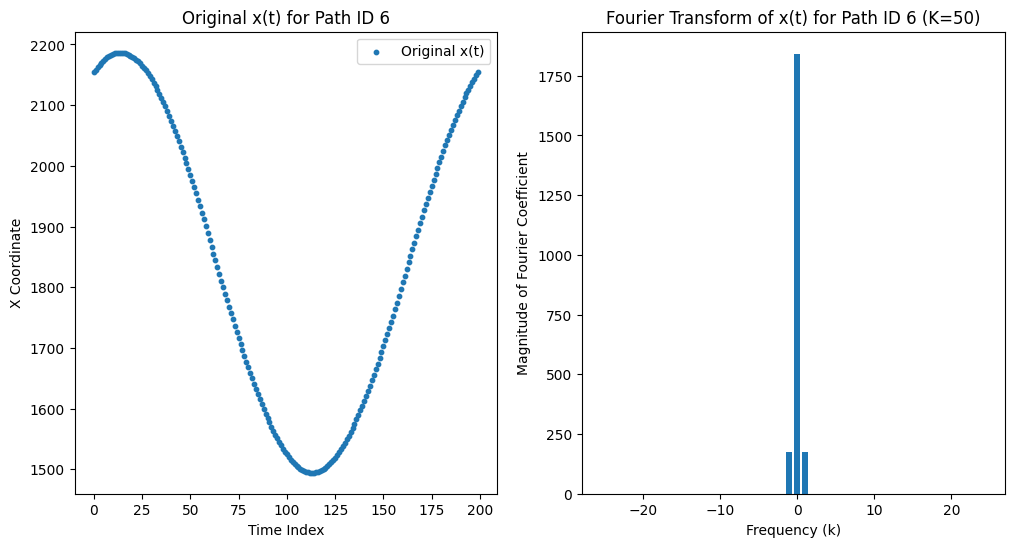

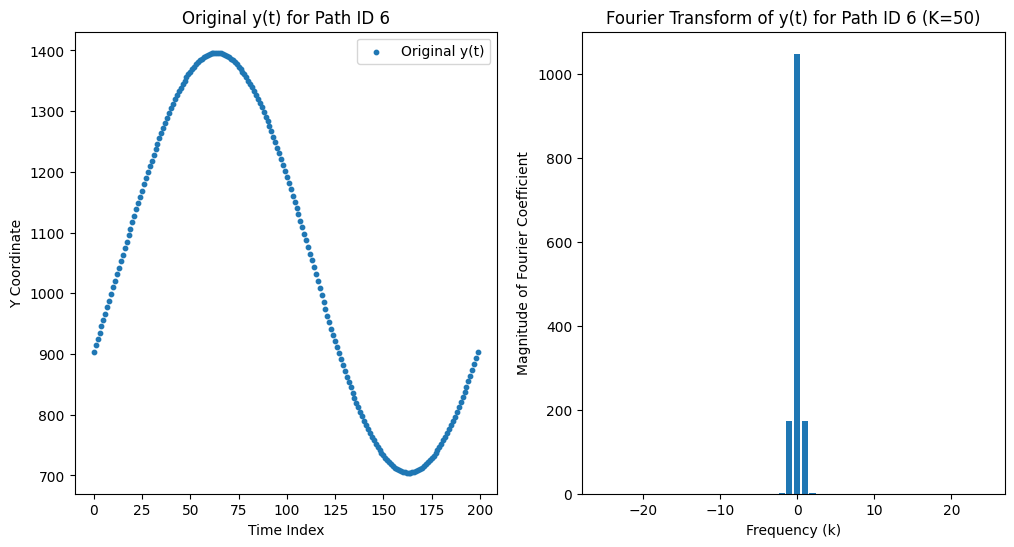

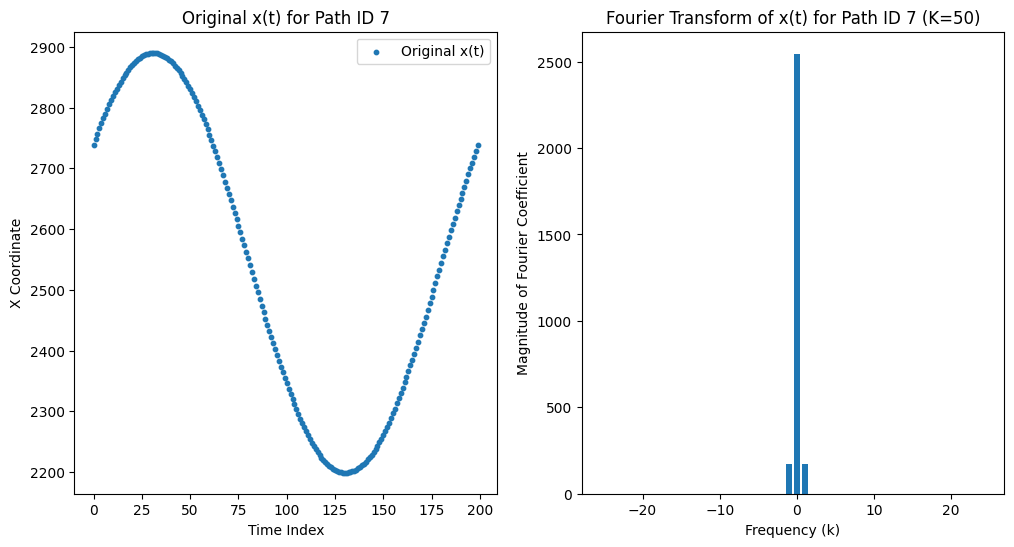

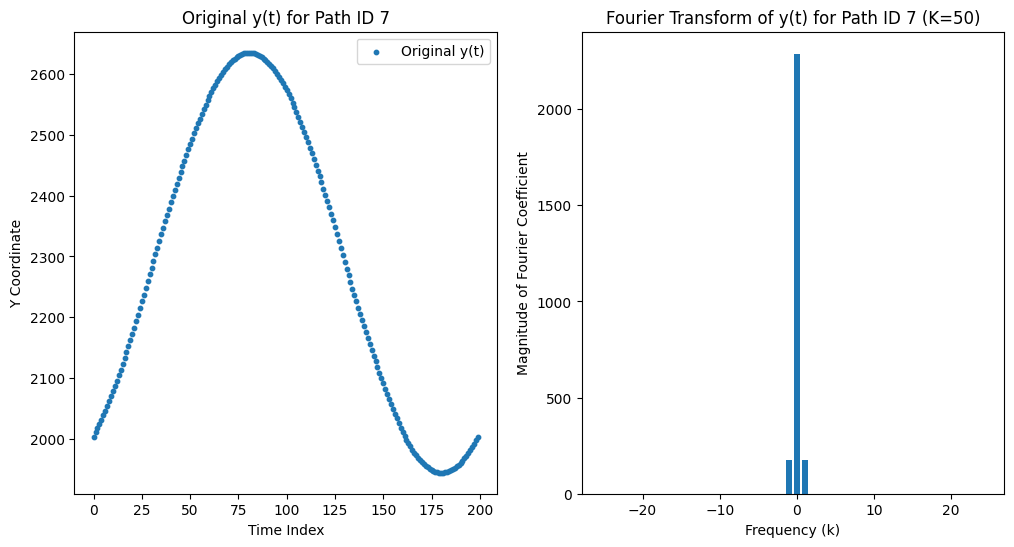

In [11]:
unique_path_ids = df_points['path_id'].unique()
K = 50

for path_id in unique_path_ids:
    df_subset = df_points[df_points['path_id'] == path_id]
    x_signal = df_subset['x'].values
    y_signal = df_subset['y'].values
    time_index = df_subset['time_index'].values

    x_fourier_coeffs = compute_Fourier_Series(x_signal, time_index, K)
    y_fourier_coeffs = compute_Fourier_Series(y_signal, time_index, K)

    # Plot original and Fourier transformed signals for x(t)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(time_index, x_signal, s=10, label='Original x(t)')
    plt.xlabel("Time Index")
    plt.ylabel("X Coordinate")
    plt.title(f"Original x(t) for Path ID {path_id}")
    plt.legend()

    plt.subplot(1, 2, 2)
    frequencies = np.fft.fftshift(np.fft.fftfreq(len(x_signal))) * len(x_signal) # Get the frequency values
    plt.bar(np.fft.fftshift(np.arange(-K//2, K//2)), np.abs(np.fft.fftshift(x_fourier_coeffs)))
    plt.xlabel("Frequency (k)")
    plt.ylabel("Magnitude of Fourier Coefficient")
    plt.title(f"Fourier Transform of x(t) for Path ID {path_id} (K={K})")
    plt.show()

    # Plot original and Fourier transformed signals for y(t)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(time_index, y_signal, s=10, label='Original y(t)')
    plt.xlabel("Time Index")
    plt.ylabel("Y Coordinate")
    plt.title(f"Original y(t) for Path ID {path_id}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(np.fft.fftshift(np.arange(-K//2, K//2)), np.abs(np.fft.fftshift(y_fourier_coeffs)))
    plt.xlabel("Frequency (k)")
    plt.ylabel("Magnitude of Fourier Coefficient")
    plt.title(f"Fourier Transform of y(t) for Path ID {path_id} (K={K})")
    plt.show()

**(c) Reconstruct the shape using a Fourier series with different values of K.**

In [12]:
def reconstruct_signal(fourier_coeffs, t):
    """Reconstructs a signal from its Fourier coefficients."""
    N = len(t)
    K = len(fourier_coeffs)
    k0 = -(K // 2)
    k = np.arange(k0, k0 + K)

    # Inverse DFT formula: x[n] = sum_{k} c_k * exp(j * 2 * pi * k * n / N)
    reconstructed_x = np.zeros(N, dtype=complex)
    for i, time in enumerate(t):
        reconstructed_x[i] = np.sum(fourier_coeffs * np.exp(1j * 2.0 * np.pi * k * time / N))

    return reconstructed_x.real

In [13]:
unique_path_ids = df_points['path_id'].unique()
K_values = [1, 3, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 350, 400]

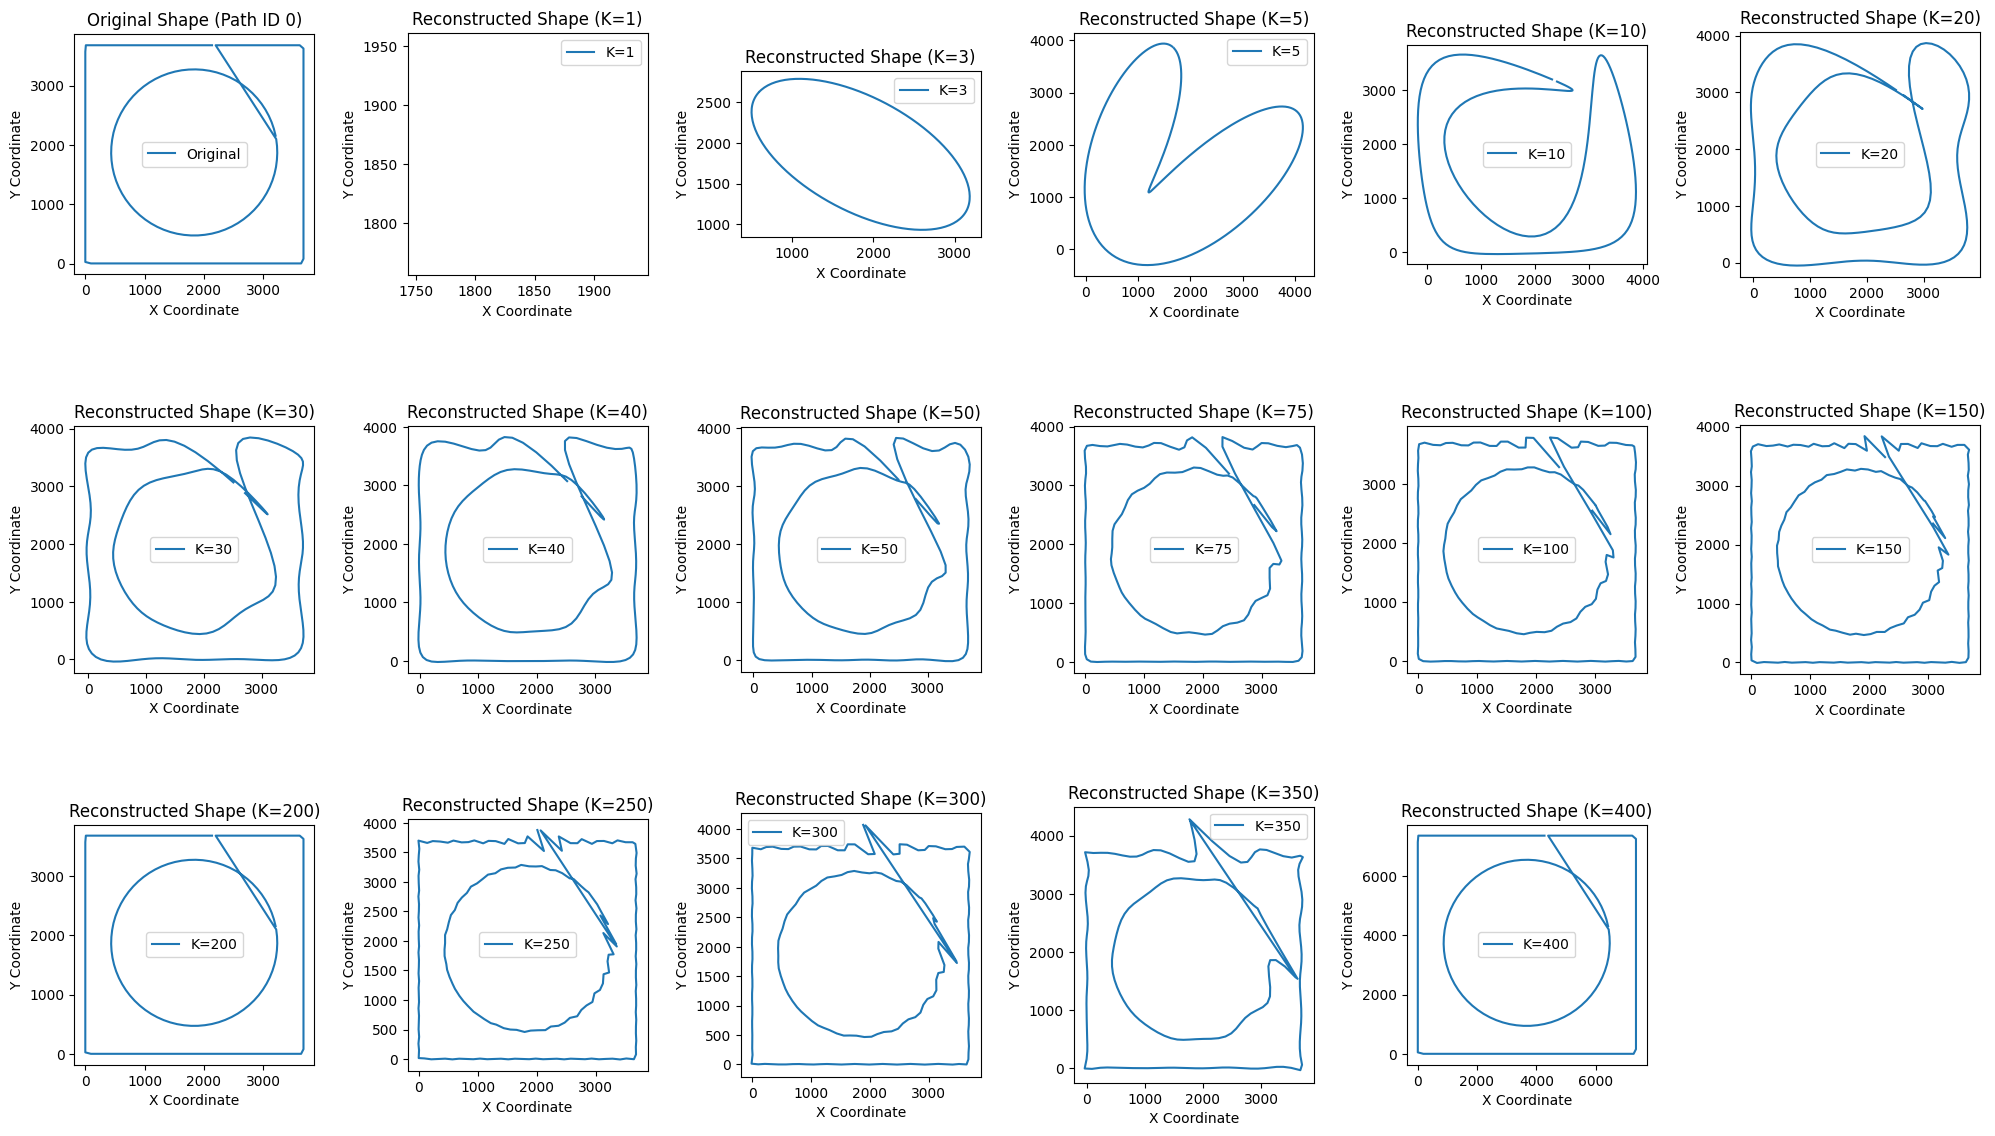

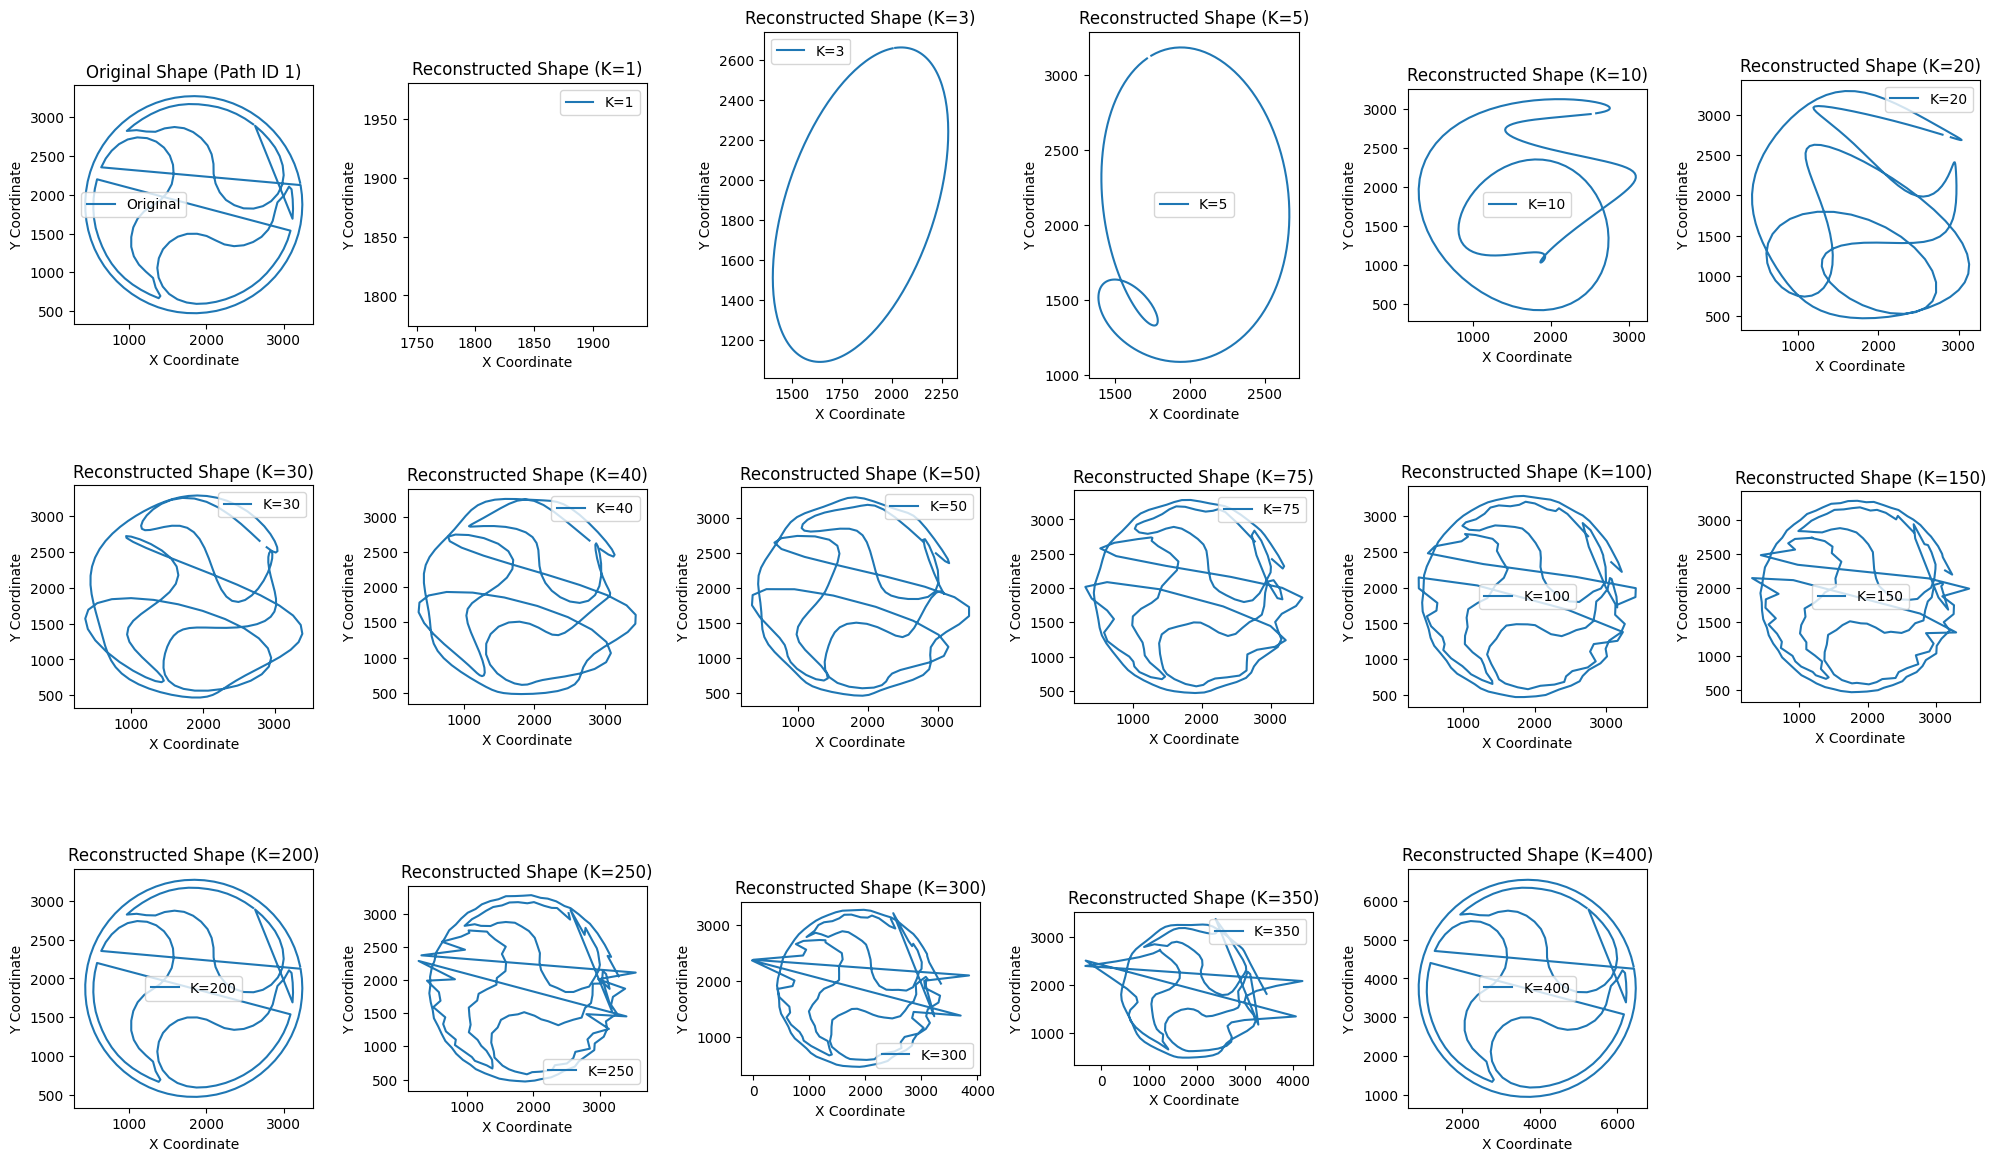

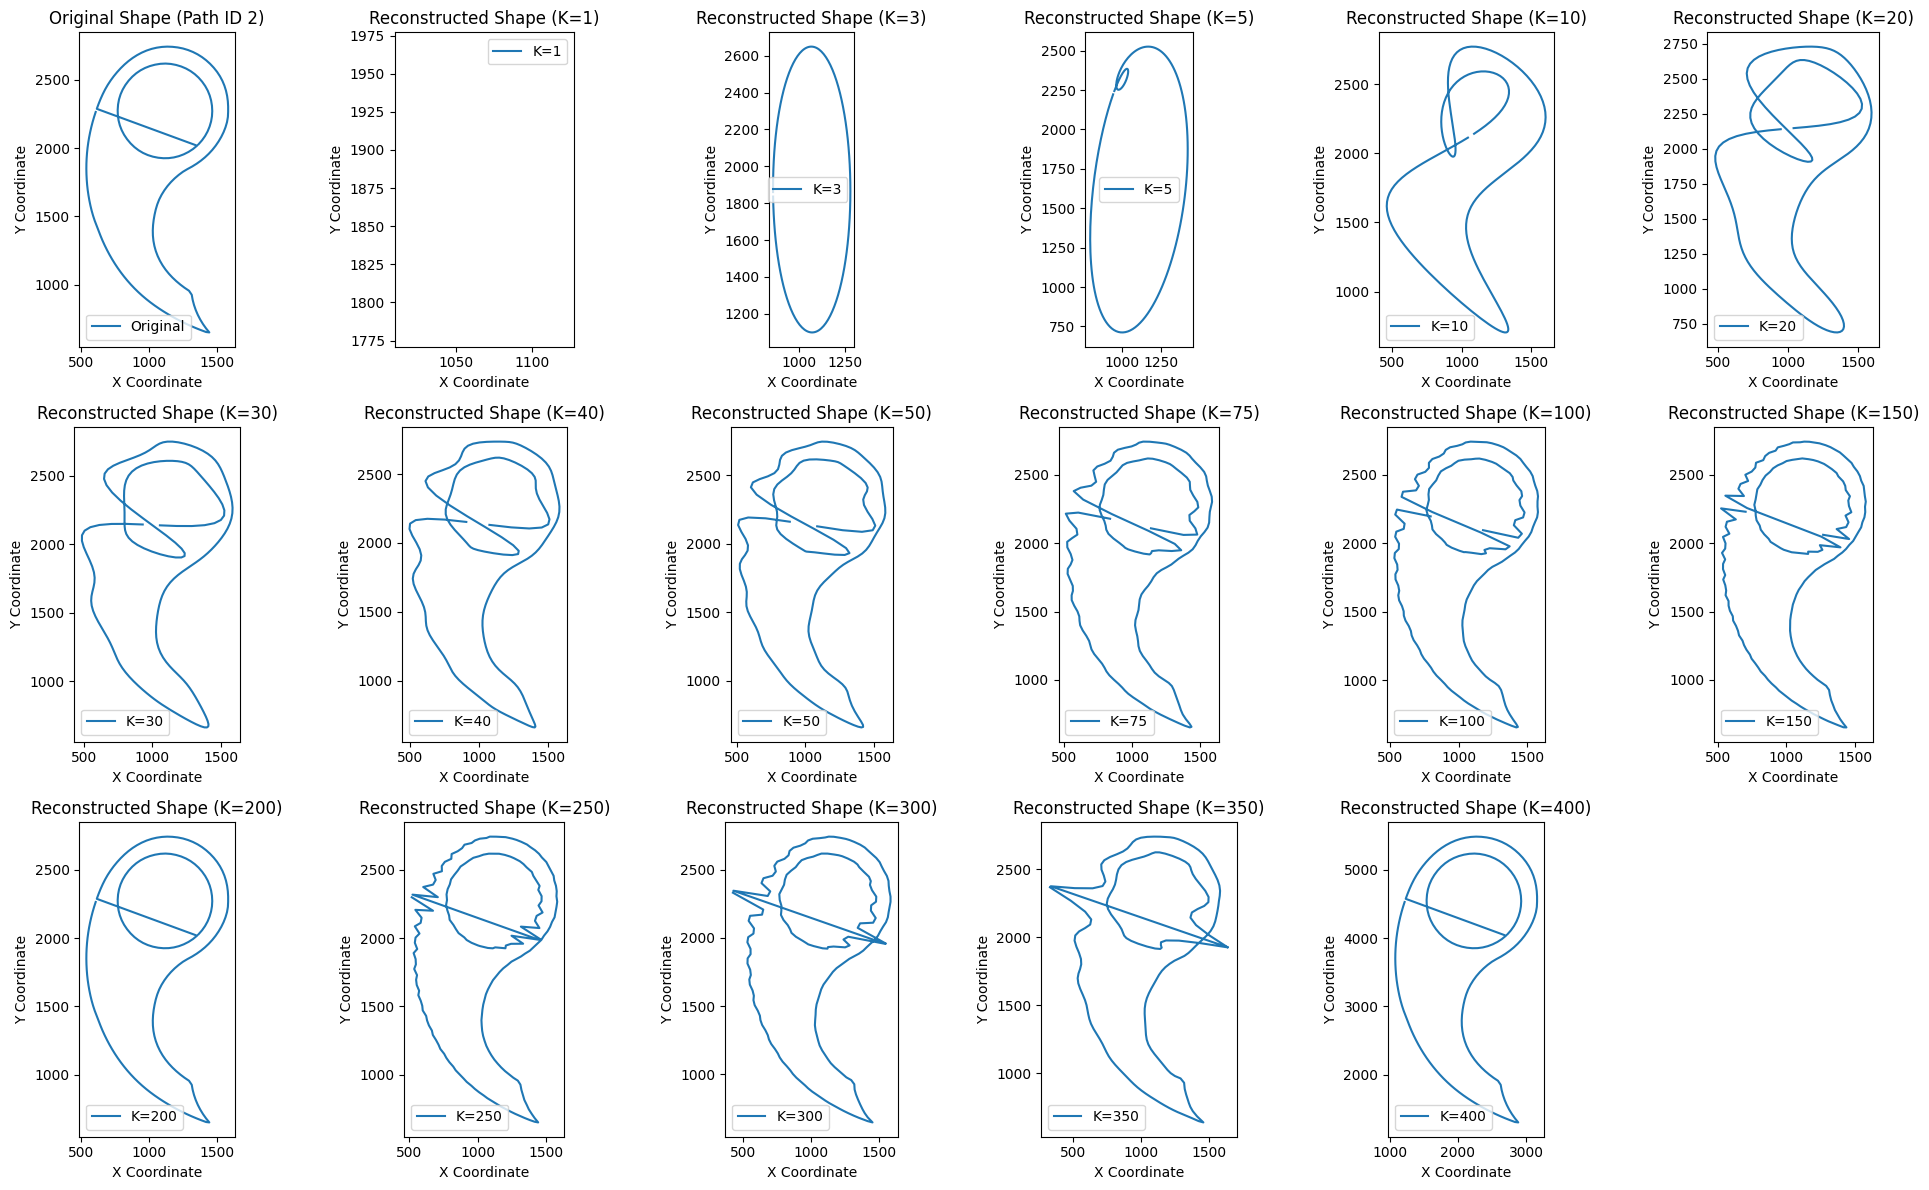

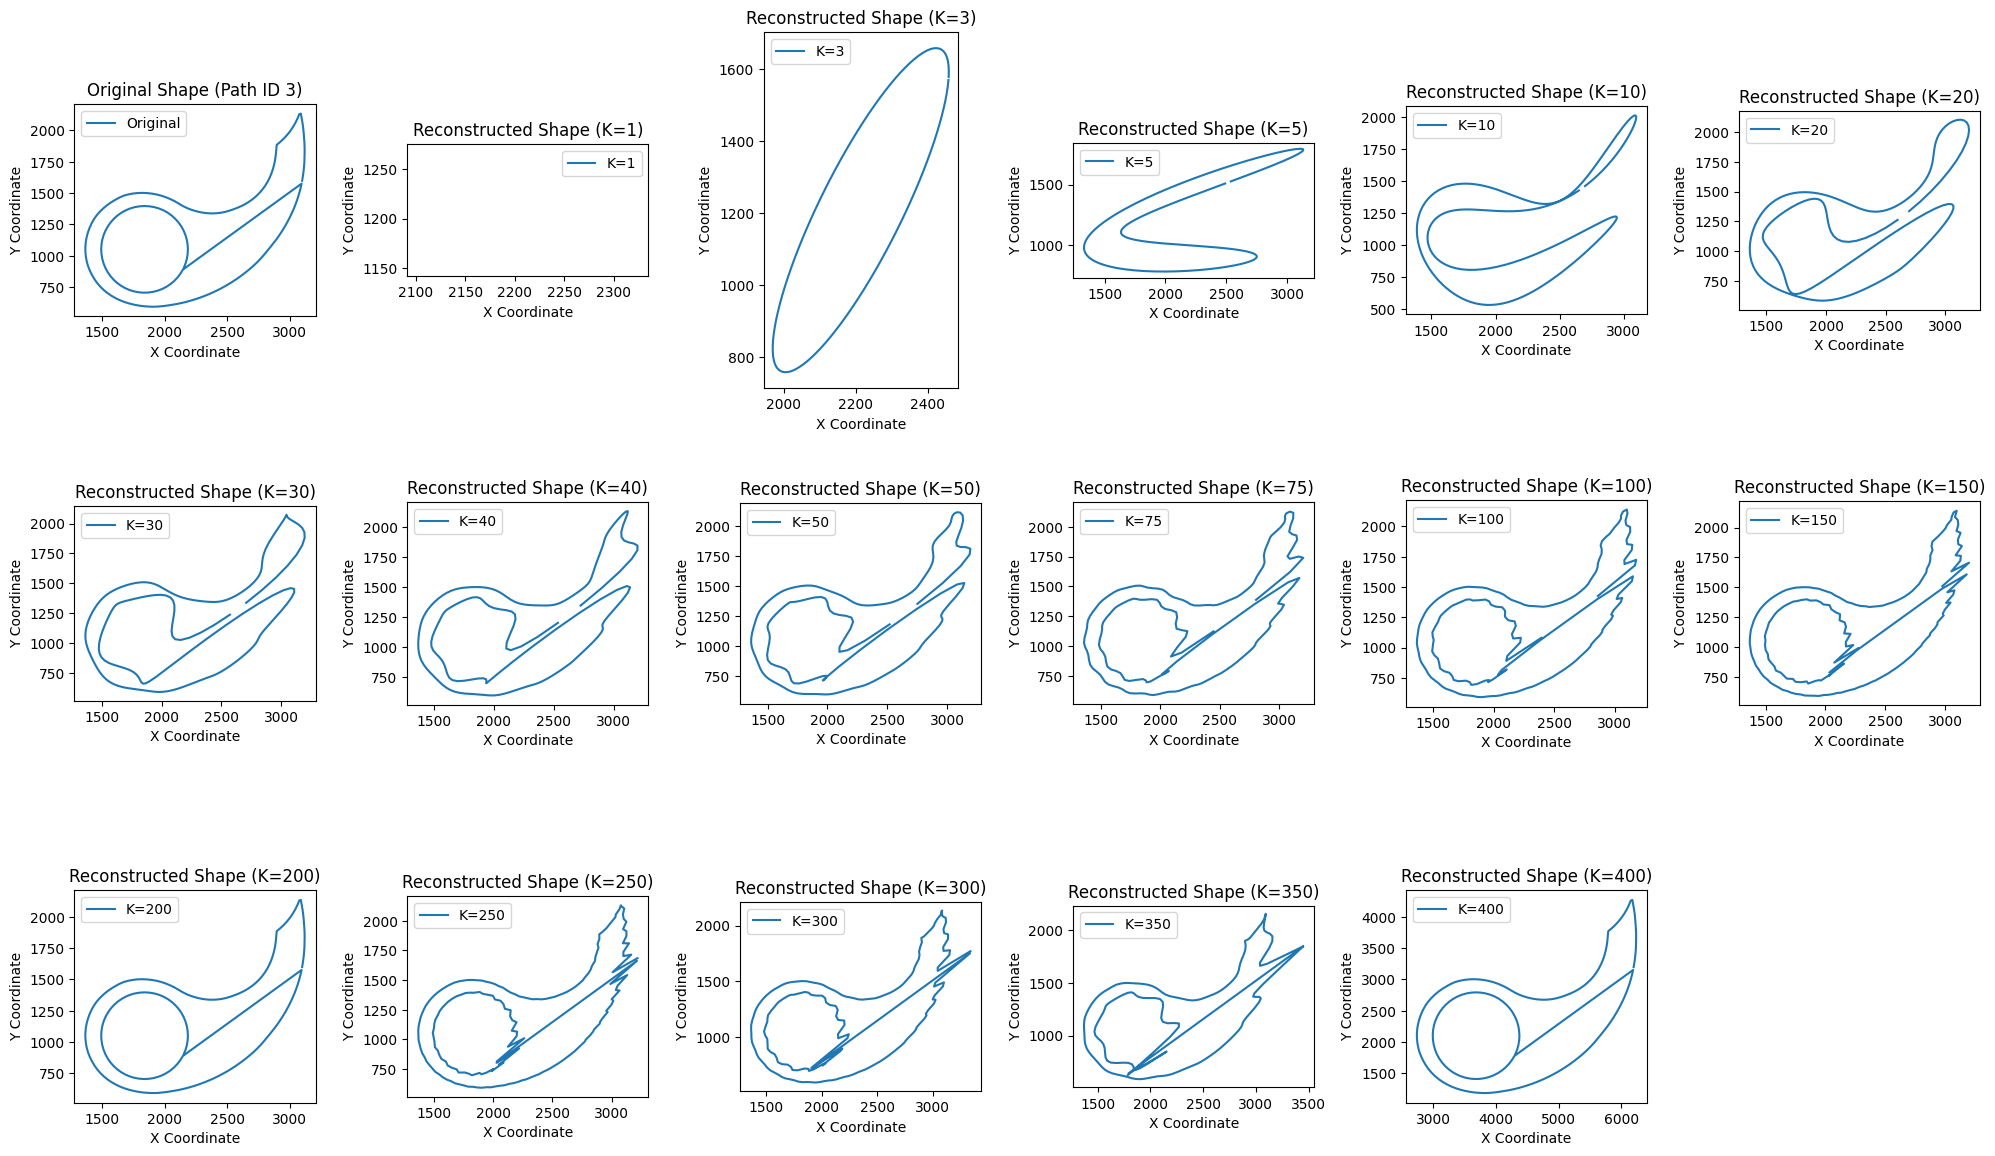

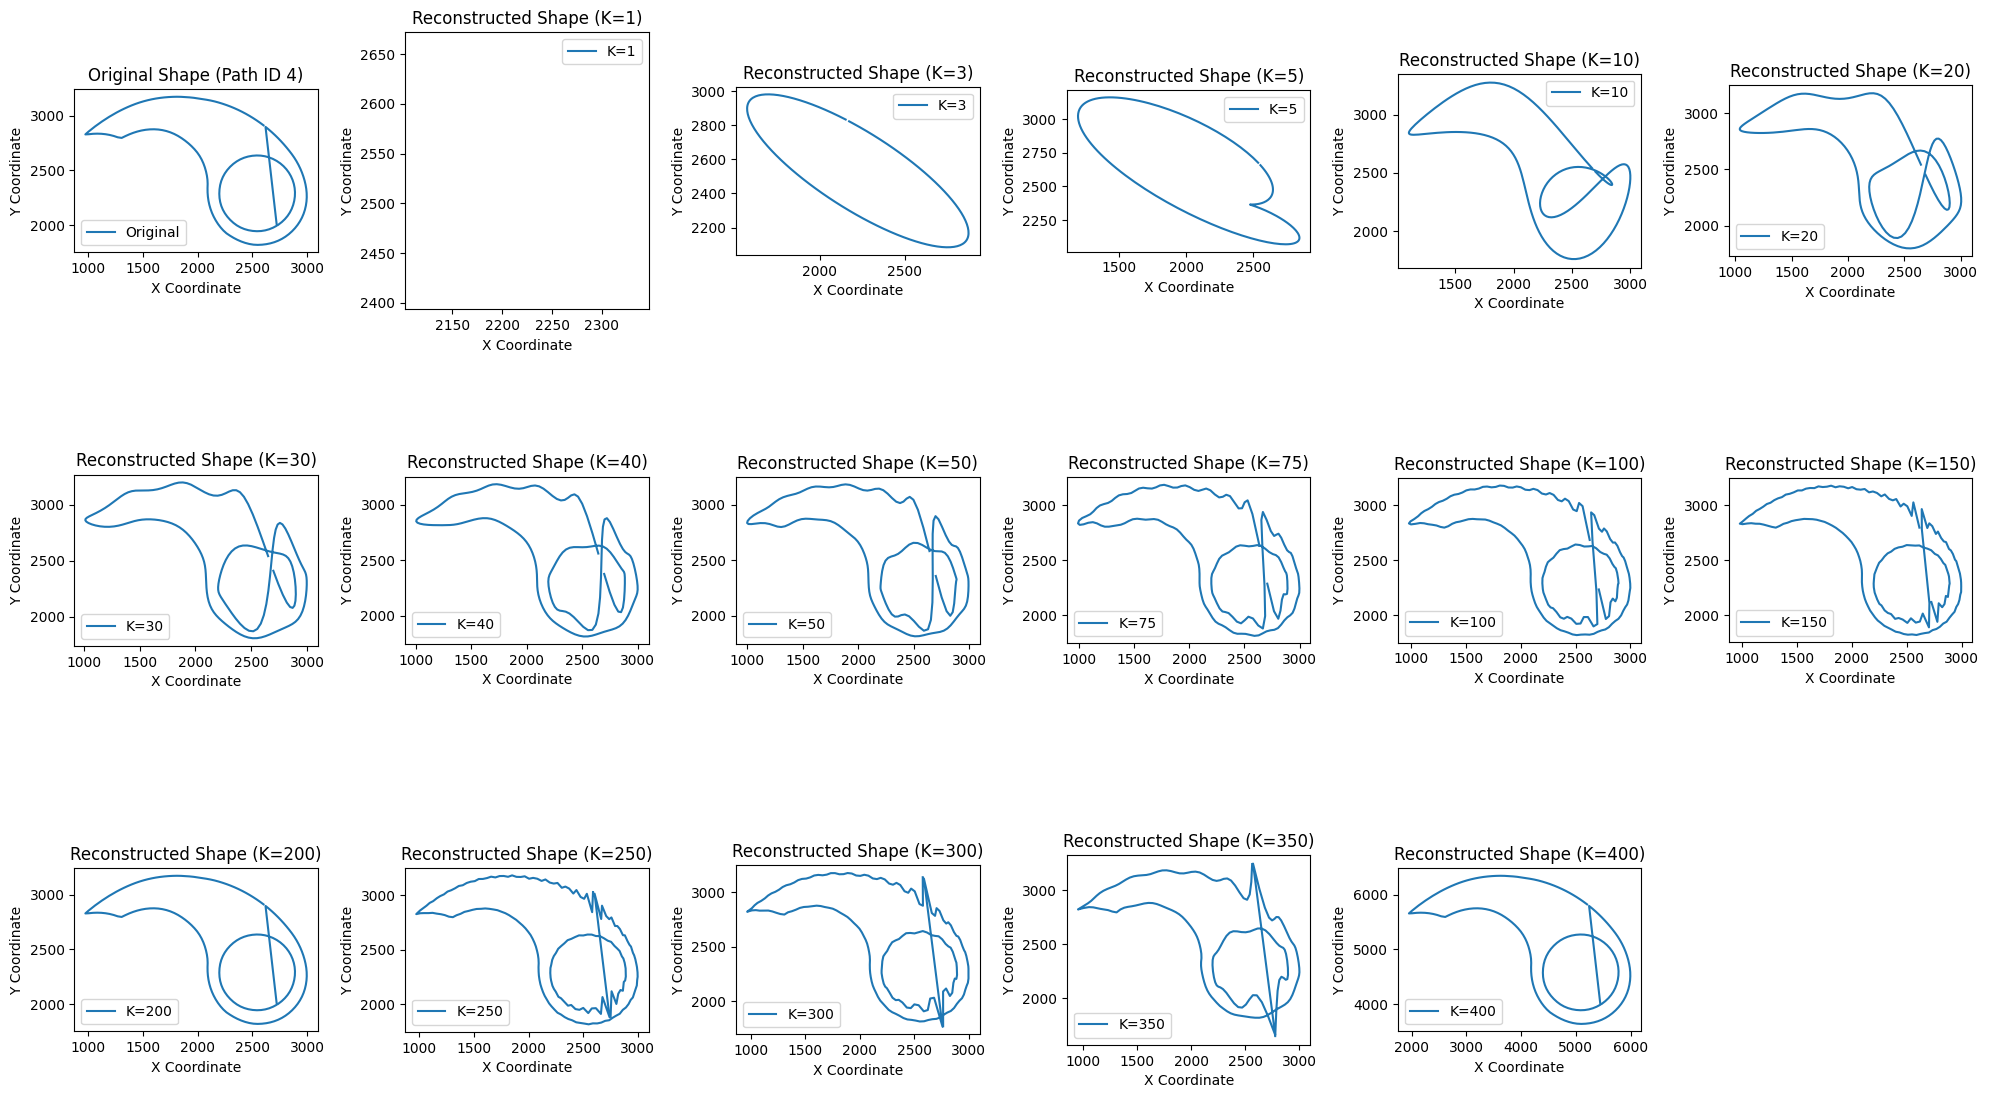

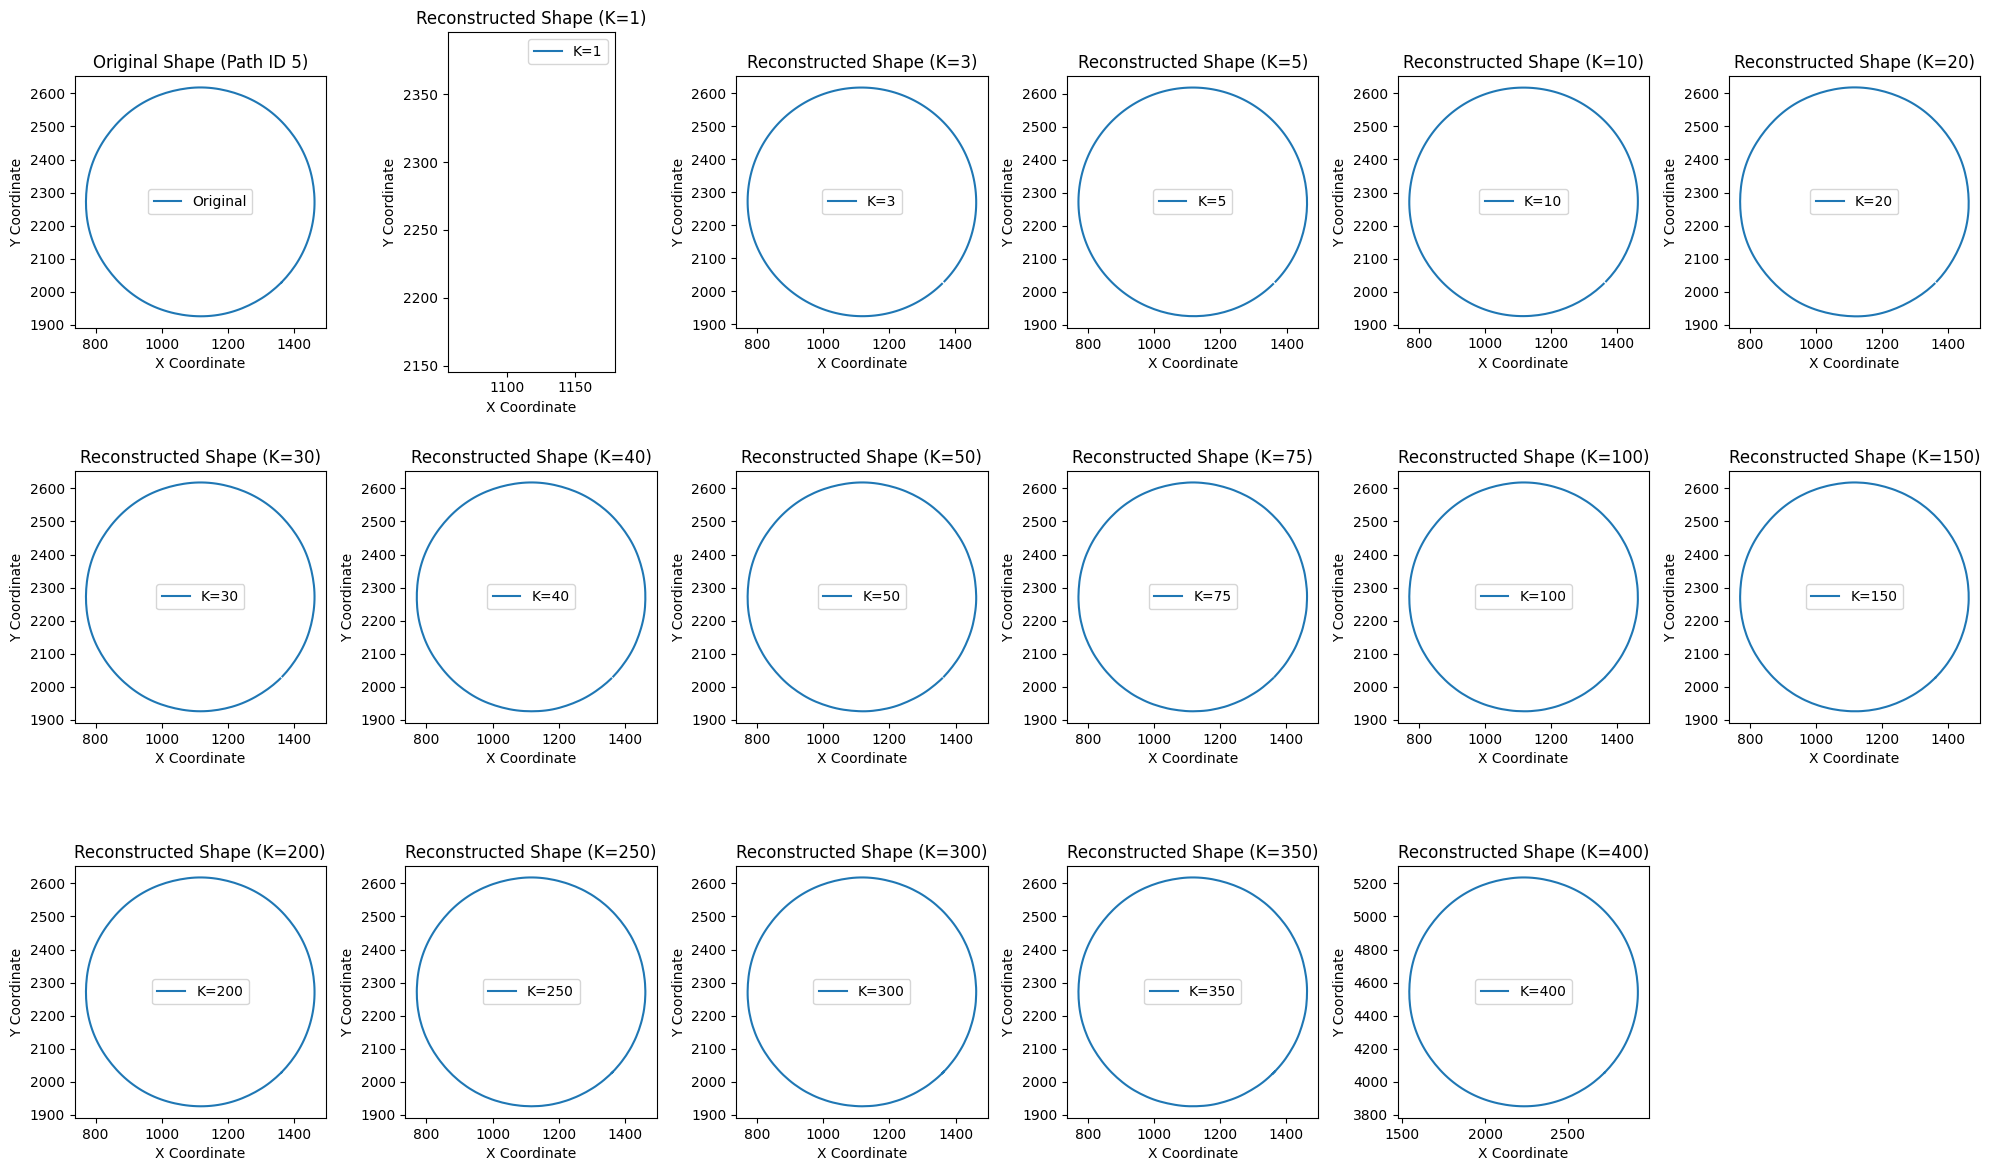

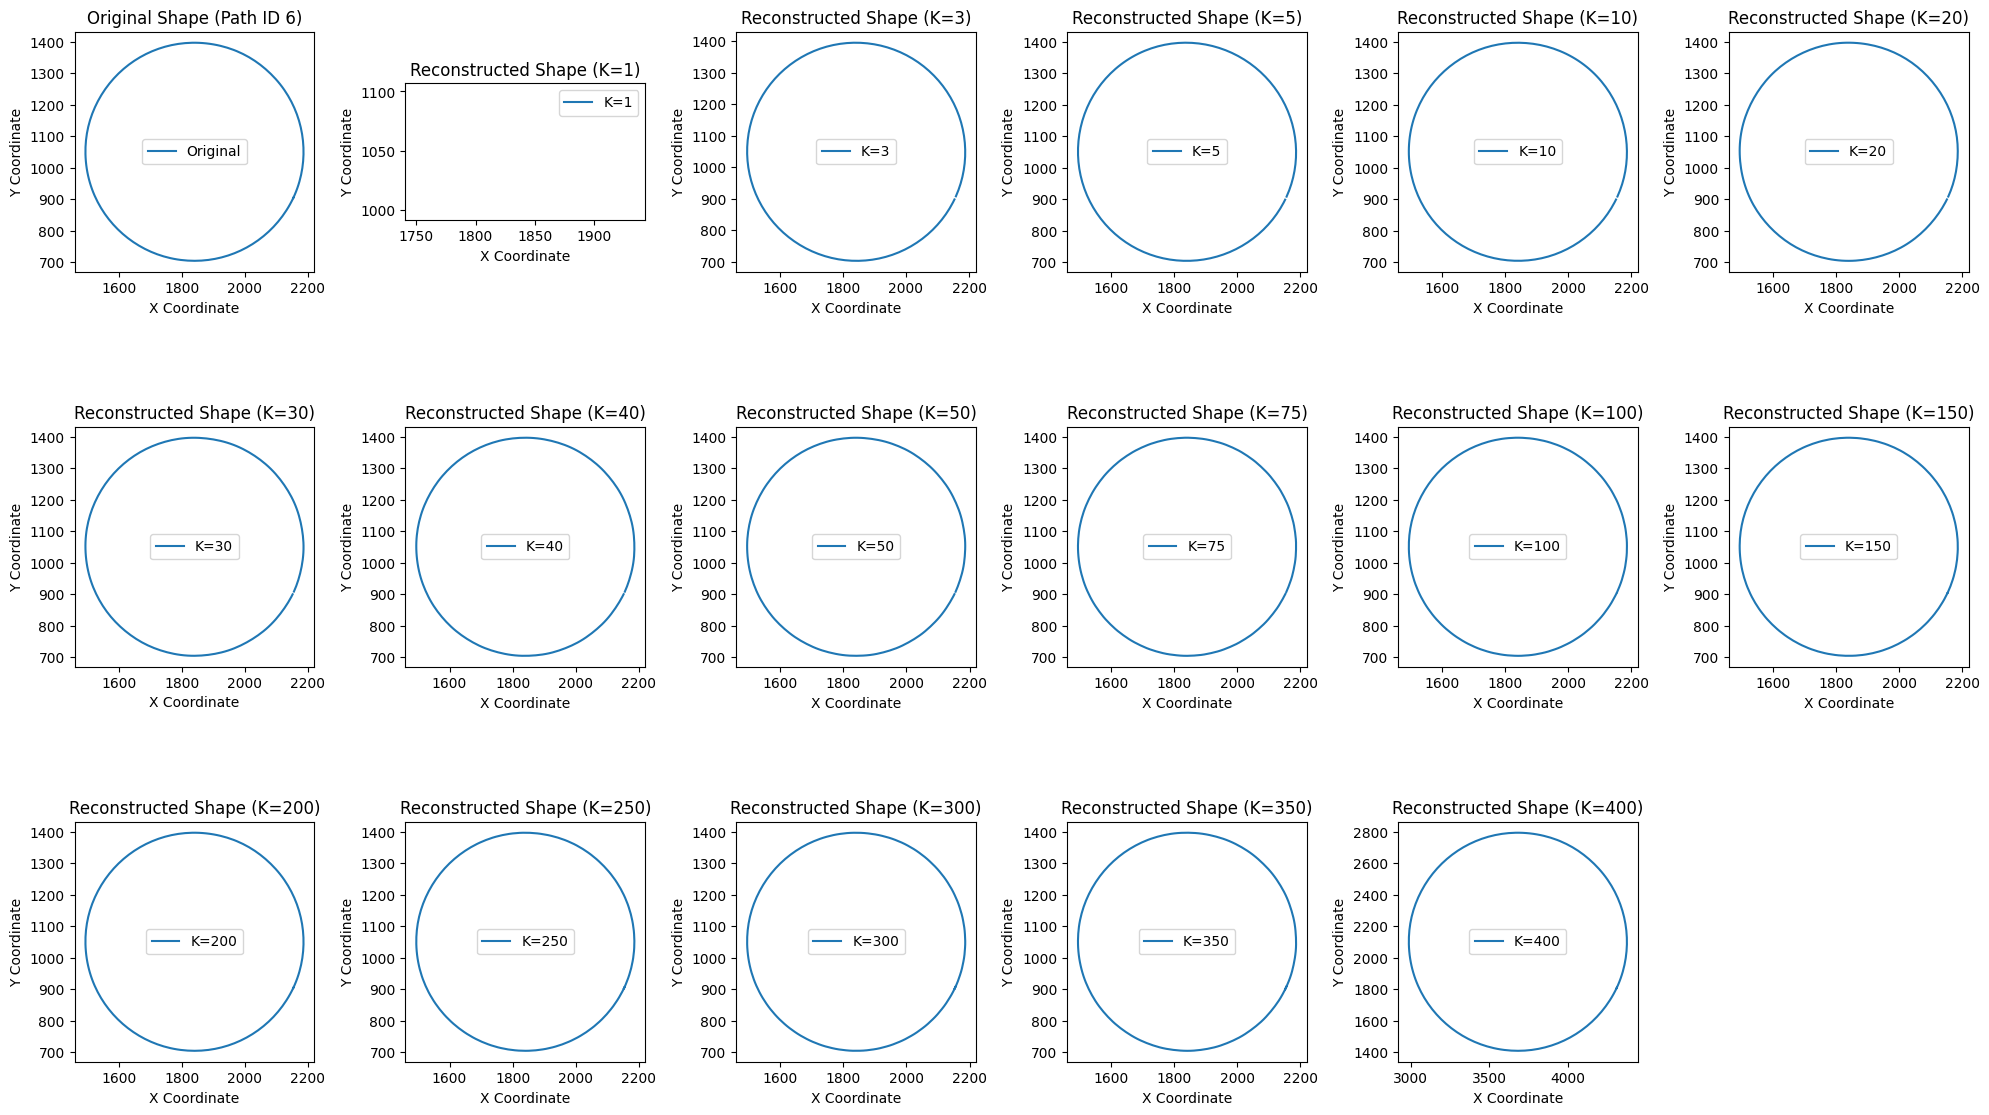

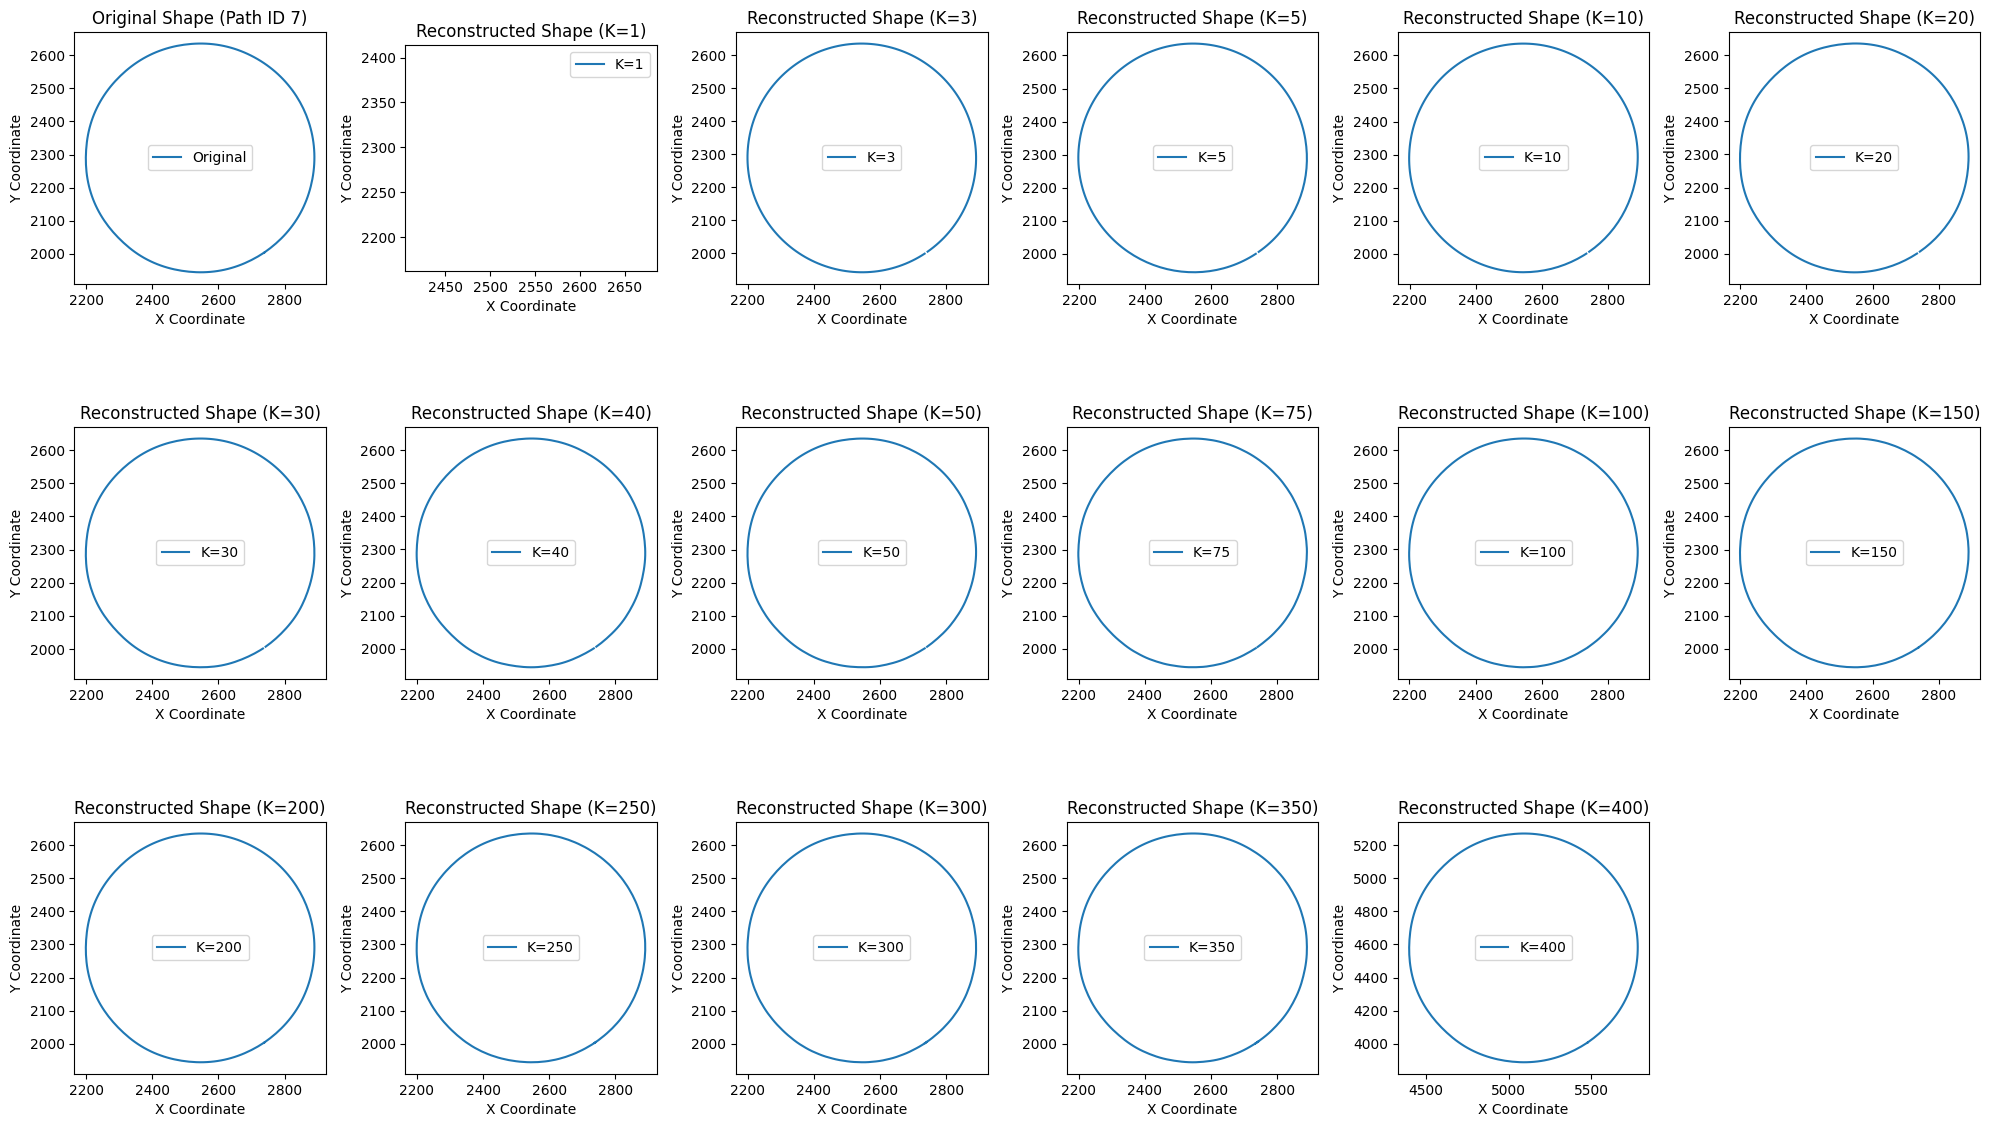

In [14]:
for path_id in unique_path_ids:
    df_subset = df_points[df_points['path_id'] == path_id].sort_values(by='time_index')
    x_signal = df_subset['x'].values
    y_signal = df_subset['y'].values
    time_index = df_subset['time_index'].values

    num_cols = 6
    num_rows = (len(K_values) + 1 + num_cols - 1) // num_cols

    plt.figure(figsize=(20, num_rows * 4))

    # Plot original shape for reference
    plt.subplot(num_rows, num_cols, 1)
    plt.plot(x_signal, y_signal, label='Original')
    plt.title(f'Original Shape (Path ID {path_id})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()

    for i, K in enumerate(K_values):

        x_fourier_coeffs = compute_Fourier_Series(x_signal, time_index, K)
        y_fourier_coeffs = compute_Fourier_Series(y_signal, time_index, K)

        reconstructed_x = reconstruct_signal(x_fourier_coeffs, time_index)
        reconstructed_y = reconstruct_signal(y_fourier_coeffs, time_index)

        plt.subplot(num_rows, num_cols, i + 2)
        plt.plot(reconstructed_x, reconstructed_y, label=f'K={K}')
        plt.title(f'Reconstructed Shape (K={K})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()

    plt.tight_layout()
    plt.show()

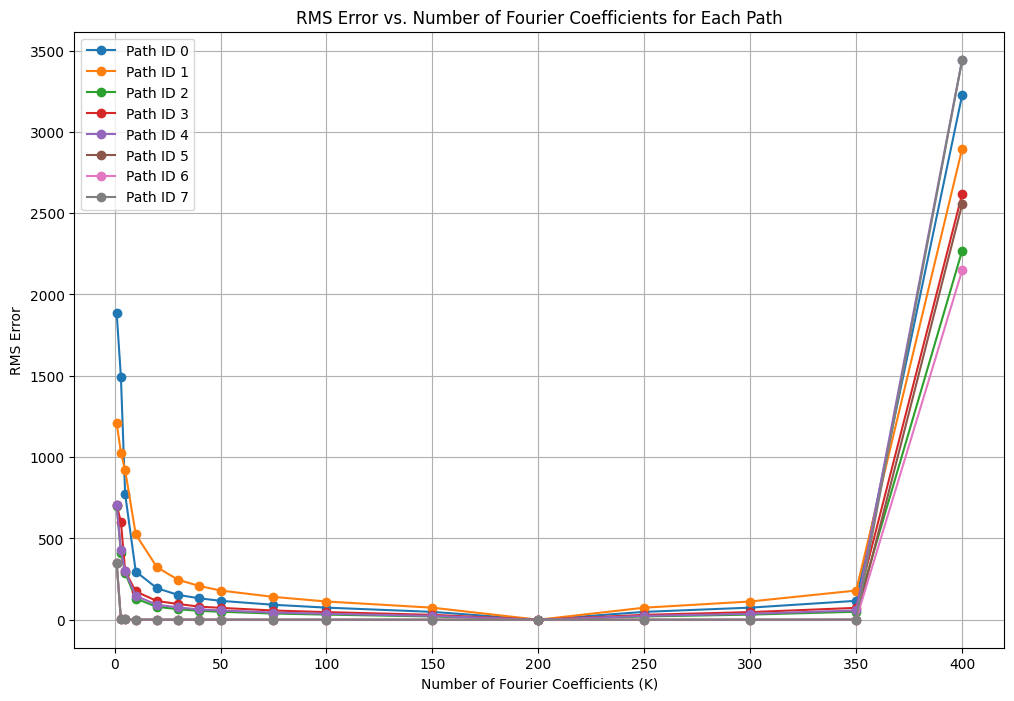

In [15]:
def compute_rms_error(original_x, original_y, reconstructed_x, reconstructed_y):
    """Computes the Root Mean Square Error between original and reconstructed shapes."""
    error_x = original_x - reconstructed_x
    error_y = original_y - reconstructed_y
    rms_error = np.sqrt(np.mean(error_x**2 + error_y**2))
    return rms_error

unique_path_ids = df_points['path_id'].unique()
K_values = [1, 3, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 350, 400]

rms_errors = defaultdict(list)

for path_id in unique_path_ids:
    df_subset = df_points[df_points['path_id'] == path_id].sort_values(by='time_index')
    x_signal = df_subset['x'].values
    y_signal = df_subset['y'].values
    time_index = df_subset['time_index'].values

    for K in K_values:

        x_fourier_coeffs = compute_Fourier_Series(x_signal, time_index, K)
        y_fourier_coeffs = compute_Fourier_Series(y_signal, time_index, K)


        reconstructed_x = reconstruct_signal(x_fourier_coeffs, time_index)
        reconstructed_y = reconstruct_signal(y_fourier_coeffs, time_index)


        error = compute_rms_error(x_signal, y_signal, reconstructed_x, reconstructed_y)
        rms_errors[path_id].append(error)

# Plot RMS error vs K for each path
plt.figure(figsize=(12, 8))
for path_id, errors in rms_errors.items():
    plt.plot(K_values, errors, marker='o', label=f'Path ID {path_id}')

plt.xlabel("Number of Fourier Coefficients (K)")
plt.ylabel("RMS Error")
plt.title("RMS Error vs. Number of Fourier Coefficients for Each Path")
plt.legend()
plt.grid(True)
plt.show()

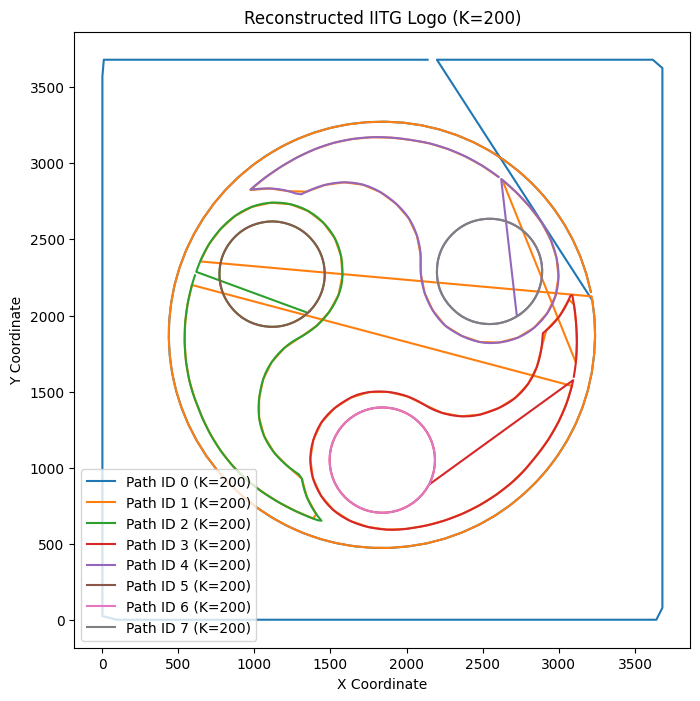

In [16]:
K_final = 200

plt.figure(figsize=(10, 8))

for path_id in unique_path_ids:
    df_subset = df_points[df_points['path_id'] == path_id].sort_values(by='time_index')
    x_signal = df_subset['x'].values
    y_signal = df_subset['y'].values
    time_index = df_subset['time_index'].values

    x_fourier_coeffs = compute_Fourier_Series(x_signal, time_index, K_final)
    y_fourier_coeffs = compute_Fourier_Series(y_signal, time_index, K_final)

    reconstructed_x = reconstruct_signal(x_fourier_coeffs, time_index)
    reconstructed_y = reconstruct_signal(y_fourier_coeffs, time_index)

    plt.plot(reconstructed_x, reconstructed_y, label=f'Path ID {path_id} (K={K_final})')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"Reconstructed IITG Logo (K={K_final})")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

In [17]:
def _fig_to_rgb_array(fig):

    fig.canvas.draw()

    try:
        width, height = fig.canvas.get_width_height()
    except Exception:

        renderer = fig.canvas.get_renderer()
        width, height = renderer.width, renderer.height

    # Try multiple methods to extract bytes -> array
    # 1) tostring_rgb (common)
    try:
        buf = fig.canvas.tostring_rgb()
        arr = np.frombuffer(buf, dtype=np.uint8).reshape((height, width, 3))
        return arr
    except Exception:
        pass

    # 2) tostring_argb (then convert ARGB->RGBA->RGB)
    try:
        buf = fig.canvas.tostring_argb()
        a = np.frombuffer(buf, dtype=np.uint8).reshape((height, width, 4))

        rgba = a[:, :, [1,2,3,0]]
        rgb = rgba[:, :, :3]
        return rgb
    except Exception:
        pass

    # 3) print_to_buffer() fallback; returns (buf, (w,h))
    try:
        buf, size = fig.canvas.print_to_buffer()
        w, h = size

        arr4 = np.frombuffer(buf, dtype=np.uint8)

        if arr4.size == w * h * 4:
            arr4 = arr4.reshape((h, w, 4))

            alpha_last = arr4[:, :, 3]
            if alpha_last.max() > 10:
                rgba = arr4
            else:

                rgba = arr4[:, :, [1,2,3,0]]
            rgb = rgba[:, :, :3]
            return rgb

    except Exception:
        pass


    try:
        renderer = fig.canvas.get_renderer()
        buf = renderer.buffer_rgba()
        arr = np.asarray(buf)
        # buffer_rgba often returns (h,w,4) RGBA
        if arr.ndim == 3 and arr.shape[2] == 4:
            # convert to RGB
            rgb = arr[:, :, :3]
            return rgb
    except Exception:
        pass


    raise RuntimeError("Could not extract RGB buffer from Matplotlib figure (tried tostring_rgb, tostring_argb, print_to_buffer, buffer_rgba).")


In [21]:
def compute_Fourier_Series(x, K):
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N == 0 or K == 0:
        return np.zeros(0, dtype=complex)
    k0 = - (K // 2)
    k = np.arange(k0, k0 + K)
    n = np.arange(N)
    exp_mat = np.exp(-1j * 2.0 * np.pi * np.outer(k, n) / N)
    c = (1.0 / N) * (exp_mat @ x)
    return c

In [22]:
def reconstruct_continuous(c, N_orig, t_cont):
    if len(c) == 0:
        return np.zeros_like(t_cont, dtype=float)
    K = len(c)
    k0 = - (K // 2)
    k = np.arange(k0, k0 + K)[:, None]
    t = t_cont[None, :]
    E = np.exp(1j * 2.0 * np.pi * k * t / N_orig)
    xr = (c[:, None] * E).sum(axis=0)
    return xr.real

In [23]:
def generate_logo_fourier_gif_robust(svg_path=None,
                                     df_points=None,
                                     out_path="iitg_8panel_trace_fixed.gif",
                                     K_values=[1,3,5,10,20,50,100,200],
                                     samples_per_path_svg=600,
                                     upsample=2,
                                     fps=20,
                                     max_samples_per_path=240,
                                     max_frames=300,
                                     skip_every=1,
                                     figsize=(12,6),
                                     dpi=100):

    if svg_path is None and df_points is None:
        raise ValueError("Provide either svg_path or df_points.")
    if svg_path is not None:

        try:
            import svgpathtools as spt
        except Exception as ex:
            raise RuntimeError("svgpathtools required to parse SVG. Install: pip install svgpathtools") from ex
        if not os.path.exists(svg_path):
            raise FileNotFoundError(f"SVG not found at {svg_path}")
        rows=[]
        for pid, path in enumerate(spt.svg2paths(svg_path)[0]):
            L = path.length()
            if L <= 0:
                continue
            t_vals = np.linspace(0, 1, samples_per_path_svg, endpoint=False)
            for i, t in enumerate(t_vals):
                pt = path.point(t)
                rows.append({'x':float(pt.real), 'y':float(pt.imag), 'time_index':int(i), 'path_id':int(pid)})
        if len(rows)==0:
            raise RuntimeError("No path points extracted from SVG.")
        df = pd.DataFrame(rows)
    else:
        if not isinstance(df_points, pd.DataFrame):
            raise TypeError("df_points must be a pandas DataFrame.")
        required = {'x','y','time_index','path_id'}
        if not required.issubset(df_points.columns):
            raise ValueError(f"df_points must contain columns: {required}")
        df = df_points.copy()

    # normalize / ensure numeric types
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df['time_index'] = df['time_index'].astype(int)
    df['path_id'] = df['path_id'].astype(int)

    # collect paths
    paths=[]
    for pid, grp in df.groupby('path_id'):
        g = grp.sort_values('time_index')
        xs = g['x'].values
        ys = g['y'].values
        N = len(xs)
        if N==0: continue
        paths.append({'path_id':int(pid),'x':xs,'y':ys,'N':N})
    if len(paths)==0:
        raise RuntimeError("No path segments found in df_points/SVG.")

    # build traces per K
    traces_by_K={}
    sep = np.array([np.nan])
    for K in K_values:
        x_parts=[]; y_parts=[]
        for p in paths:
            N=p['N']
            M = min(int(max(8, N*upsample)), max_samples_per_path)
            t_cont = np.linspace(0, N-1, M)
            cx = compute_Fourier_Series(p['x'], K)
            cy = compute_Fourier_Series(p['y'], K)
            rx = reconstruct_continuous(cx, N, t_cont)
            ry = reconstruct_continuous(cy, N, t_cont)
            x_parts.append(np.asarray(rx).reshape(-1)); x_parts.append(sep)
            y_parts.append(np.asarray(ry).reshape(-1)); y_parts.append(sep)
        if len(x_parts)==0:
            Xk=np.array([]); Yk=np.array([])
        else:
            Xk=np.concatenate(x_parts); Yk=np.concatenate(y_parts)
        traces_by_K[K]=(Xk,Yk)

    total_len = max((len(v[0]) for v in traces_by_K.values()), default=0)
    if total_len==0:
        raise RuntimeError("Traces empty. Check inputs and K_values.")
    frames = int(min(total_len, max_frames))
    frames = max(1, frames)

    # figure & axes
    n_panels = len(K_values)
    ncols = min(4, n_panels)
    nrows = math.ceil(n_panels / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    # compute limits across traces
    lims={'xmin':np.inf,'xmax':-np.inf,'ymin':np.inf,'ymax':-np.inf}
    for Xk,Yk in traces_by_K.values():
        if Xk.size==0: continue
        valid = ~np.isnan(Xk)
        if valid.any():
            xv=Xk[valid]; yv=Yk[valid]
            lims['xmin']=min(lims['xmin'], xv.min()); lims['xmax']=max(lims['xmax'], xv.max())
            lims['ymin']=min(lims['ymin'], yv.min()); lims['ymax']=max(lims['ymax'], yv.max())
    if lims['xmin']==np.inf:
        lims={'xmin':-1,'xmax':1,'ymin':-1,'ymax':1}
    padx=(lims['xmax']-lims['xmin'])*0.06 if lims['xmax']>lims['xmin'] else 1.0
    pady=(lims['ymax']-lims['ymin'])*0.06 if lims['ymax']>lims['ymin'] else 1.0

    lines=[]; dots=[]
    for idx,K in enumerate(K_values):
        ax=axes[idx]
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(lims['xmin']-padx, lims['xmax']+padx)
        ax.set_ylim(lims['ymin']-pady, lims['ymax']+pady)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"K = {K}")
        ln, = ax.plot([], [], lw=1.6)
        dt, = ax.plot([], [], 'o', markersize=4)
        lines.append(ln); dots.append(dt)
    for j in range(len(K_values), len(axes)):
        axes[j].axis('off')

    # function to safely set sequence on line
    def set_seq_safe(line_obj, xseq, yseq):
        x = np.asarray(xseq).reshape(-1) if xseq is not None else np.array([])
        y = np.asarray(yseq).reshape(-1) if yseq is not None else np.array([])
        if x.size==0 or y.size==0 or x.shape[0]!=y.shape[0]:
            line_obj.set_data([], [])
        else:
            line_obj.set_data(x, y)

    # update frame
    def update_frame(i):
        for idx,K in enumerate(K_values):
            Xk,Yk = traces_by_K[K]
            L = len(Xk)
            if L==0:
                lines[idx].set_data([], []); dots[idx].set_data([], []); continue
            upto = int((i / (frames - 1)) * (L - 1)) + 1 if frames>1 else L
            upto = max(1, min(upto, L))
            # find last valid index j to avoid NaNs at segment boundaries
            j = upto - 1
            while j >= 0 and (np.isnan(Xk[j]) or np.isnan(Yk[j])):
                j -= 1
            if j >= 0:
                set_seq_safe(lines[idx], Xk[:j+1], Yk[:j+1])
                set_seq_safe(dots[idx], [Xk[j]], [Yk[j]])
            else:
                lines[idx].set_data([], []); dots[idx].set_data([], [])

    # manual capture loop using _fig_to_rgb_array
    captured = []
    for i in range(frames):
        update_frame(i)
        arr = _fig_to_rgb_array(fig)   # H x W x 3 uint8
        pil = Image.fromarray(arr)
        if (i % skip_every) == 0:
            captured.append(pil.copy())

    plt.close(fig)
    if len(captured) == 0:
        raise RuntimeError("No frames captured. Try increasing max_frames or decreasing skip_every.")
    duration = int(1000 / fps)
    captured[0].save(out_path, save_all=True, append_images=captured[1:], duration=duration, loop=0)
    return out_path


In [24]:
out = generate_logo_fourier_gif_robust(df_points=df_points, max_samples_per_path=120, max_frames=200, fps=15)
print("Saved ->", out)


Saved -> iitg_8panel_trace_fixed.gif


In [25]:
def generate_logo_fourier_gif_robust_final(svg_path=None,
                                     df_points=None,
                                     out_path="iitg_final_trace_fixed.gif",
                                     K_values=[200],
                                     samples_per_path_svg=600,
                                     upsample=2,
                                     fps=20,
                                     max_samples_per_path=240,
                                     max_frames=300,
                                     skip_every=1,
                                     figsize=(12,6),
                                     dpi=100):

    if svg_path is None and df_points is None:
        raise ValueError("Provide either svg_path or df_points.")
    if svg_path is not None:

        try:
            import svgpathtools as spt
        except Exception as ex:
            raise RuntimeError("svgpathtools required to parse SVG. Install: pip install svgpathtools") from ex
        if not os.path.exists(svg_path):
            raise FileNotFoundError(f"SVG not found at {svg_path}")
        rows=[]
        for pid, path in enumerate(spt.svg2paths(svg_path)[0]):
            L = path.length()
            if L <= 0:
                continue
            t_vals = np.linspace(0, 1, samples_per_path_svg, endpoint=False)
            for i, t in enumerate(t_vals):
                pt = path.point(t)
                rows.append({'x':float(pt.real), 'y':float(pt.imag), 'time_index':int(i), 'path_id':int(pid)})
        if len(rows)==0:
            raise RuntimeError("No path points extracted from SVG.")
        df = pd.DataFrame(rows)
    else:
        if not isinstance(df_points, pd.DataFrame):
            raise TypeError("df_points must be a pandas DataFrame.")
        required = {'x','y','time_index','path_id'}
        if not required.issubset(df_points.columns):
            raise ValueError(f"df_points must contain columns: {required}")
        df = df_points.copy()

    # normalize / ensure numeric types
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df['time_index'] = df['time_index'].astype(int)
    df['path_id'] = df['path_id'].astype(int)

    # collect paths
    paths=[]
    for pid, grp in df.groupby('path_id'):
        g = grp.sort_values('time_index')
        xs = g['x'].values
        ys = g['y'].values
        N = len(xs)
        if N==0: continue
        paths.append({'path_id':int(pid),'x':xs,'y':ys,'N':N})
    if len(paths)==0:
        raise RuntimeError("No path segments found in df_points/SVG.")

    # build traces per K
    traces_by_K={}
    sep = np.array([np.nan])
    for K in K_values:
        x_parts=[]; y_parts=[]
        for p in paths:
            N=p['N']
            M = min(int(max(8, N*upsample)), max_samples_per_path)
            t_cont = np.linspace(0, N-1, M)
            cx = compute_Fourier_Series(p['x'], K)
            cy = compute_Fourier_Series(p['y'], K)
            rx = reconstruct_continuous(cx, N, t_cont)
            ry = reconstruct_continuous(cy, N, t_cont)
            x_parts.append(np.asarray(rx).reshape(-1)); x_parts.append(sep)
            y_parts.append(np.asarray(ry).reshape(-1)); y_parts.append(sep)
        if len(x_parts)==0:
            Xk=np.array([]); Yk=np.array([])
        else:
            Xk=np.concatenate(x_parts); Yk=np.concatenate(y_parts)
        traces_by_K[K]=(Xk,Yk)

    total_len = max((len(v[0]) for v in traces_by_K.values()), default=0)
    if total_len==0:
        raise RuntimeError("Traces empty. Check inputs and K_values.")
    frames = int(min(total_len, max_frames))
    frames = max(1, frames)

    # figure & axes
    n_panels = len(K_values)
    ncols = min(4, n_panels)
    nrows = math.ceil(n_panels / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    # compute limits across traces
    lims={'xmin':np.inf,'xmax':-np.inf,'ymin':np.inf,'ymax':-np.inf}
    for Xk,Yk in traces_by_K.values():
        if Xk.size==0: continue
        valid = ~np.isnan(Xk)
        if valid.any():
            xv=Xk[valid]; yv=Yk[valid]
            lims['xmin']=min(lims['xmin'], xv.min()); lims['xmax']=max(lims['xmax'], xv.max())
            lims['ymin']=min(lims['ymin'], yv.min()); lims['ymax']=max(lims['ymax'], yv.max())
    if lims['xmin']==np.inf:
        lims={'xmin':-1,'xmax':1,'ymin':-1,'ymax':1}
    padx=(lims['xmax']-lims['xmin'])*0.06 if lims['xmax']>lims['xmin'] else 1.0
    pady=(lims['ymax']-lims['ymin'])*0.06 if lims['ymax']>lims['ymin'] else 1.0

    lines=[]; dots=[]
    for idx,K in enumerate(K_values):
        ax=axes[idx]
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(lims['xmin']-padx, lims['xmax']+padx)
        ax.set_ylim(lims['ymin']-pady, lims['ymax']+pady)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"K = {K}")
        ln, = ax.plot([], [], lw=1.6)
        dt, = ax.plot([], [], 'o', markersize=4)
        lines.append(ln); dots.append(dt)
    for j in range(len(K_values), len(axes)):
        axes[j].axis('off')

    # function to safely set sequence on line
    def set_seq_safe(line_obj, xseq, yseq):
        x = np.asarray(xseq).reshape(-1) if xseq is not None else np.array([])
        y = np.asarray(yseq).reshape(-1) if yseq is not None else np.array([])
        if x.size==0 or y.size==0 or x.shape[0]!=y.shape[0]:
            line_obj.set_data([], [])
        else:
            line_obj.set_data(x, y)

    # update frame
    def update_frame(i):
        for idx,K in enumerate(K_values):
            Xk,Yk = traces_by_K[K]
            L = len(Xk)
            if L==0:
                lines[idx].set_data([], []); dots[idx].set_data([], []); continue
            upto = int((i / (frames - 1)) * (L - 1)) + 1 if frames>1 else L
            upto = max(1, min(upto, L))
            # find last valid index j to avoid NaNs at segment boundaries
            j = upto - 1
            while j >= 0 and (np.isnan(Xk[j]) or np.isnan(Yk[j])):
                j -= 1
            if j >= 0:
                set_seq_safe(lines[idx], Xk[:j+1], Yk[:j+1])
                set_seq_safe(dots[idx], [Xk[j]], [Yk[j]])
            else:
                lines[idx].set_data([], []); dots[idx].set_data([], [])

    # manual capture loop using _fig_to_rgb_array
    captured = []
    for i in range(frames):
        update_frame(i)
        arr = _fig_to_rgb_array(fig)   # H x W x 3 uint8
        pil = Image.fromarray(arr)
        if (i % skip_every) == 0:
            captured.append(pil.copy())

    plt.close(fig)
    if len(captured) == 0:
        raise RuntimeError("No frames captured. Try increasing max_frames or decreasing skip_every.")
    duration = int(1000 / fps)
    captured[0].save(out_path, save_all=True, append_images=captured[1:], duration=duration, loop=0)
    return out_path


In [26]:
out = generate_logo_fourier_gif_robust_final(df_points=df_points, max_samples_per_path=120, max_frames=200, fps=15)
print("Saved ->", out)


Saved -> iitg_final_trace_fixed.gif


**(d) Comment on the trade-off between the number of Fourier terms and the reconstruction quality. Why does Fourier series allow us to capture even highly irregular shapes? Can you think of real-world applications of this exercise?**
<br>
<br>
**Trade-off between the number of Fourier terms (K) and reconstruction quality:**

From the reconstructed shapes for different K values and the RMS error plot, there is a clear trade-off.

*   **Low K:** With a small number of Fourier terms, the reconstructed shape is a very rough approximation of the original. Many details are lost, and the shape appears simplified or distorted. The RMS error is high.

*   **Increasing K:** As the number of Fourier terms increases, the reconstructed shape becomes progressively closer to the original. More details and complexities of the contour are captured. The RMS error decreases significantly as K increases, especially initially.

*   **High K:** With a large number of Fourier terms, the reconstructed shape is a very good approximation of the original. The RMS error is low. However, using too many terms can sometimes lead to minor oscillations or artifacts in the reconstruction, especially with noisy data or sharp corners. There's a point of diminishing returns where increasing K provides little improvement in visual quality but increases computational cost.

The optimal K value depends on the desired level of accuracy and the computational resources available. For a good balance, we might choose a K where the RMS error starts to level off.
<br>
<br>
**Why Fourier series can capture irregular shapes:**

Fourier series work by representing a complex periodic signal as a sum of simple sine and cosine waves (or complex exponentials) of different frequencies and amplitudes. Even highly irregular shapes, when represented as parametric functions of a traversal parameter (like time index in this case), can be viewed as periodic signals (assuming a closed loop or repeating pattern). The irregular features of the shape correspond to higher frequencies in the Fourier transform. By including enough of these high-frequency components (i.e., using a sufficiently large K), the Fourier series can accurately reconstruct the sharp turns, corners, and intricate details of the original shape. Essentially, the Fourier series decomposes the complex shape into its fundamental frequency components, and by summing these components, we can rebuild the original shape.
<br>
<br>
**Real-world applications:**

This exercise has several real-world applications:

*   **Shape Analysis and Recognition:** Fourier descriptors (coefficients derived from the Fourier series of a shape's contour) can be used to represent and compare shapes for tasks like object recognition, pattern matching, and classification in computer vision.
*   **Image Compression:** Fourier transforms are fundamental to many image compression techniques (like JPEG). By keeping only the most significant Fourier coefficients, we can represent an image with fewer data while retaining most of the important visual information.
*   **Medical Imaging:** Fourier analysis is used in techniques like MRI (Magnetic Resonance Imaging) to reconstruct images from collected data.
*   **Signal Processing:** Fourier series and transforms are widely used in analyzing and processing various signals, including audio, electrical, and mechanical signals.
*   **Computer Graphics and Animation:** Fourier series can be used to represent and manipulate curves and shapes in computer graphics and for creating animations of evolving shapes.
*   **Data Compression and Filtering:** In various data analysis tasks, Fourier analysis can be used to identify and filter out noise or compress data by keeping only the most important frequency components.